# Solution Planning

https://docs.google.com/document/d/e/2PACX-1vQ1TppeFwJHR8m_fO6vh94Eh94UXDFxokWC6U7szUt20vlSl85FqV__tOIUykfRUJ6sDnkCbMcEtF09/pub

# 0.0. Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from IPython.display import HTML
from IPython.display import Image
from geopy.geocoders import Nominatim

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import dummy
from sklearn import metrics
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

## 0.1. Helper Functions

In [148]:
def performance_metrics_cv( estimator, X, y, model_name, cv=3 ):
    _precision = cross_val_score(estimator, X, y, scoring='precision', cv=cv)
    _recall = cross_val_score(estimator, X, y, scoring='recall', cv=cv)
    _f1 = cross_val_score(estimator, X, y, scoring='f1', cv=cv)
    _accuracy = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv)
    _roc_auc = cross_val_score(estimator, X, y, scoring='roc_auc', cv=cv)
    
    
    dict_ = {
        'Model Name': model_name,
        'precision': f'{round(np.mean(_precision), 4)}    +/-   {round(np.std(_precision), 4)}',
        'recall':    f'{round(np.mean(_recall), 4)}    +/-   {round(np.std(_recall), 4)}',
        'f1_score':  f'{round(np.mean(_f1), 4)}    +/-   {round(np.std(_f1), 4)}',
        'accuracy':  f'{round(np.mean(_accuracy), 4)}    +/-   {round(np.std(_accuracy), 4)}',
        'roc_auc':  f'{round(np.mean(_roc_auc), 4)}    +/-   {round(np.std(_roc_auc), 4)}'
    }
    return pd.DataFrame( dict_, index=[0] )

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [4]:
df_raw = pd.read_csv( '../data/raw/churn.csv' )

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

 ## **Features**

* **NowNumber:** O número da coluna
* **CustomerID:** Identificador único do cliente
* **Surname:** Sobrenome do cliente.
* **CreditScore:** A pontuação de Crédito do cliente para o mercado de consumo.
* **Geography:** O país onde o cliente reside.
* **Gender:** O gênero do cliente.
* **Age:** A idade do cliente.
* **Tenure:** Número de anos que o cliente permaneceu ativo.
* **Balance:** Valor monetário que o cliente tem em sua conta bancária.
* **NumOfProducts:** O número de produtos comprado pelo cliente no banco.
* **HasCrCard:** Indica se o cliente possui ou não cartão de crédito.
* **IsActiveMember:** Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
* **EstimateSalary:** Estimativa do salário mensal do cliente.
* **Exited:** Indica se o cliente está ou não em Churn.

In [6]:
df1.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'exited']

## 1.2. Data Dimensions

In [7]:
df1.shape

(10000, 14)

## 1.3. Check NA

In [8]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.4. Data Dtypes

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5. Descriptive Statistics 

In [10]:
num_attr = df1.select_dtypes( include=['int64', 'float64'] )
cat_attr = df1.select_dtypes( include=['object'] )

### 1.5.1. Numerical Attributes

In [11]:
# tendency central: mean, median
ct1 = pd.DataFrame( num_attr.apply(np.mean) )
ct2 = pd.DataFrame( num_attr.apply(np.median) )

# dispersion: min,  max, range, std
d1 = pd.DataFrame( num_attr.apply(np.min) )
d2 = pd.DataFrame( num_attr.apply(np.max) )
d3 = pd.DataFrame( num_attr.apply(lambda x: np.max(x) - np.min(x)) )
d4 = pd.DataFrame( num_attr.apply(lambda x: x.std()) )

# shape: skew, kurtosis
s1 = pd.DataFrame( num_attr.apply(lambda x: x.skew()) )
s2 = pd.DataFrame( num_attr.apply(lambda x: x.kurtosis()) )

m1 = pd.concat([d1, d2, d3 ,ct1, ct2, d4, s1, s2], axis=1).reset_index()
m1.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.0000,10000.0000,9999.0000,5000.5000,5000.5000,2886.8957,0.0000,-1.2000
1,customer_id,15565701.0000,15815690.0000,249989.0000,15690940.5694,15690738.0000,71936.1861,0.0011,-1.1961
2,credit_score,350.0000,850.0000,500.0000,650.5288,652.0000,96.6533,-0.0716,-0.4257
3,age,18.0000,92.0000,74.0000,38.9218,37.0000,10.4878,1.0113,1.3953
4,tenure,0.0000,10.0000,10.0000,5.0128,5.0000,2.8922,0.0110,-1.1652
5,balance,0.0000,250898.0900,250898.0900,76485.8893,97198.5400,62397.4052,-0.1411,-1.4894
6,num_of_products,1.0000,4.0000,3.0000,1.5302,1.0000,0.5817,0.7456,0.5830
7,has_cr_card,0.0000,1.0000,1.0000,0.7055,1.0000,0.4558,-0.9018,-1.1870
8,is_active_member,0.0000,1.0000,1.0000,0.5151,1.0000,0.4998,-0.0604,-1.9967
9,estimated_salary,11.5800,199992.4800,199980.9000,100090.2399,100193.9150,57510.4928,0.0021,-1.1815


#### num_of_products

In [12]:
df1['num_of_products'].value_counts(normalize=True)

1   0.5084
2   0.4590
3   0.0266
4   0.0060
Name: num_of_products, dtype: float64

#### has_cr_card

In [13]:
df1['has_cr_card'].value_counts(normalize=True)

1   0.7055
0   0.2945
Name: has_cr_card, dtype: float64

#### is_active_member

In [14]:
df1['is_active_member'].value_counts(normalize=True)

1   0.5151
0   0.4849
Name: is_active_member, dtype: float64

#### exited

In [15]:
df1['exited'].value_counts(normalize=True)

0   0.7963
1   0.2037
Name: exited, dtype: float64

### 1.5.2. Categorical Attributes

In [16]:
cat_attr.describe().T

,count,unique,top,freq
surname,10000,2932,Smith,32
geography,10000,3,France,5014
gender,10000,2,Male,5457


#### geography

In [17]:
df1['geography'].value_counts(normalize=True)

France    0.5014
Germany   0.2509
Spain     0.2477
Name: geography, dtype: float64

#### gender

In [18]:
df1['gender'].value_counts(normalize=True)

Male     0.5457
Female   0.4543
Name: gender, dtype: float64

# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de hipóteses

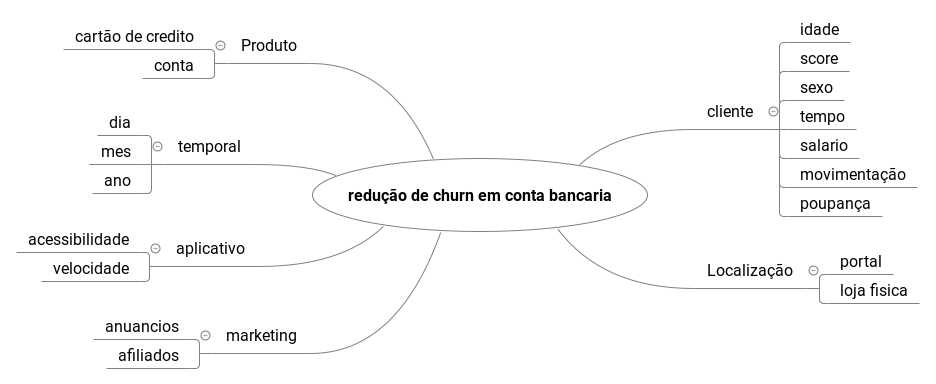

In [20]:
Image('../images/mindmap-churn.png')

## 2.2. Criação de Hipóteses

 ## **Cliente**

1. Clientes entre 40 a 60 anos, têm menos chance de abandonar o serviço comparado ao resto da baixo.
2. Cliente com score card abaixo de 400 tem mais chances de abandonar o serviço.
3. Clientes do sexo feminino tem 60% de manter o serviço.
4. Cliente acima de 5 anos usando o  serviço tem 80% de chance de manter o serviço.
5. Clientes que têm salário acima da média, têm mais chances de abandonar o serviço.
6. Clientes que fazem 10 movimentações ao mês, têm mais chances de manter o serviço.
7. Clientes que não têm dinheiro na poupança têm mais chances de abandonar o serviço.

## **Localização**
1. Clientes residentes na residentes na Espanha tem mais chances de manter o serviço em comparação comparado aos outros países
2. Clientes que acessam mais o portal têm mais chances de abandonar o serviço.


## **Marketing**
1. Clientes provenientes de de afiliados, têm mais chances de manter o serviço.
2. Anúncios de marketing são responsáveis pela maior quantidade de novos clientes, e não são mais fiéis à empresa do que por outros meios.

## **Produtos**
1. Clientes que possuem cartão de crédito, tem mais chances de manter o serviço dos que não tem.


## 2.3. Priorização de Hipóteses

* **h1.** Clientes entre 40 a 60 anos, têm menos chance de abandonar o serviço comparado ao resto da baixo.
* **h2.** Cliente com score card abaixo de 400 tem mais chances de abandonar o serviço.
* **h3.** Clientes do sexo feminino tem 60% de manter o serviço.
* **h4.** Cliente acima de 5 anos usando o  serviço tem 80% de chance de manter o serviço.
* **h5.** Clientes que têm salário acima da média, têm mais chances de abandonar o serviço.
* **h6.** Clientes que não têm dinheiro na poupança têm mais chances de abandonar o serviço.
* **h7.** Clientes residentes na residentes na Espanha tem mais chances de manter o serviço em comparação comparado aos outros países
* **h8.** Clientes que possuem cartão de crédito, tem mais chances de manter o serviço dos que não tem.


## 2.4. Create Feature

In [21]:
geolocator = Nominatim(user_agent="country_analysis")

df2.loc[ df2['geography'] == 'France', 'country_lat'] = float(geolocator.geocode('France').raw['lat'])
df2.loc[ df2['geography'] == 'Germany', 'country_lat'] = float(geolocator.geocode('Germany').raw['lat'])
df2.loc[ df2['geography'] == 'Spain', 'country_lat'] = float(geolocator.geocode('Spain').raw['lat'])

df2.loc[ df2['geography'] == 'France', 'country_lon'] = float(geolocator.geocode('France').raw['lon'])
df2.loc[ df2['geography'] == 'Germany', 'country_lon'] = float(geolocator.geocode('Germany').raw['lon'])
df2.loc[ df2['geography'] == 'Spain', 'country_lon'] = float(geolocator.geocode('Spain').raw['lon'])

In [22]:
df2.loc[(df2['age'] >= 17) & (df2['age'] <= 39), 'age_group'] = '18-39'
df2.loc[(df2['age'] >= 40) & (df2['age'] <= 59), 'age_group'] = '40-59'
df2.loc[df2['age'] >= 60, 'age_group'] = '>60'

In [23]:
df2.loc[df2['balance'] == 0, 'balance_status'] = 'without_balance'
df2.loc[df2['balance'] > 0, 'balance_status'] = 'with_balance'

# 3.0. Data Filtering

In [24]:
df3 = df2.copy()

In [25]:
drop_cols = ['row_number', 'surname']
df3 = df3.drop(drop_cols, axis=1)

# 4.0. EDA

In [26]:
df4 = df3.copy()

## 4.1. Analysis Univariate

### 4.1.1. Numerical

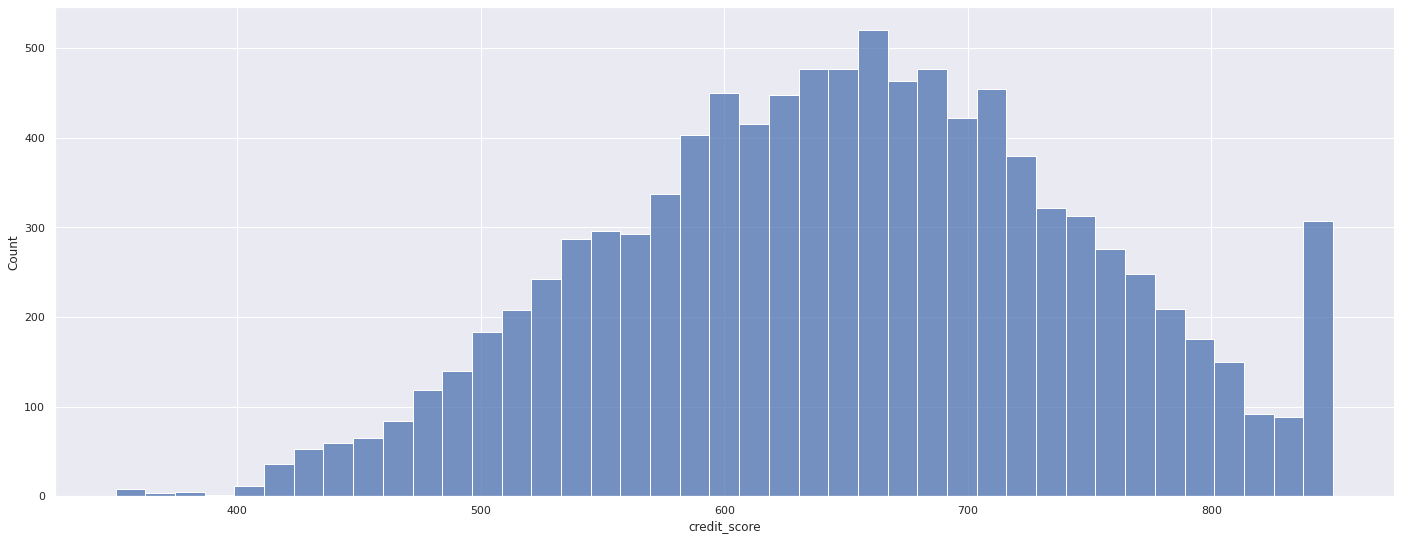

In [27]:
sns.histplot(data=df4['credit_score'] );

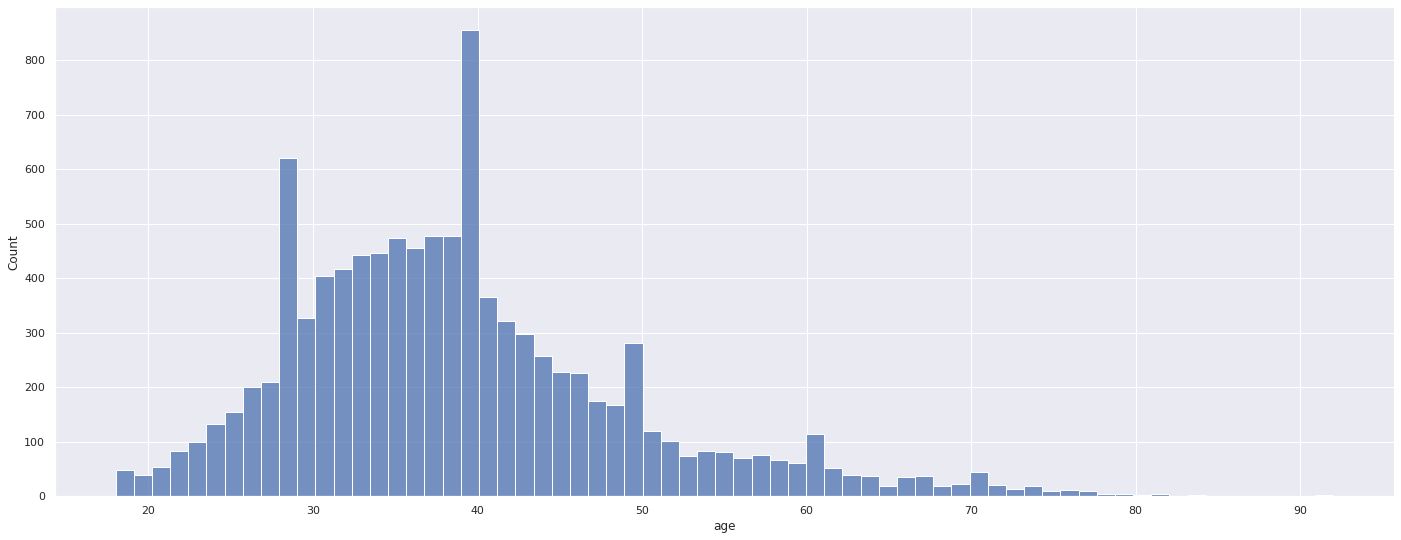

In [28]:
sns.histplot(data=df4['age'] );

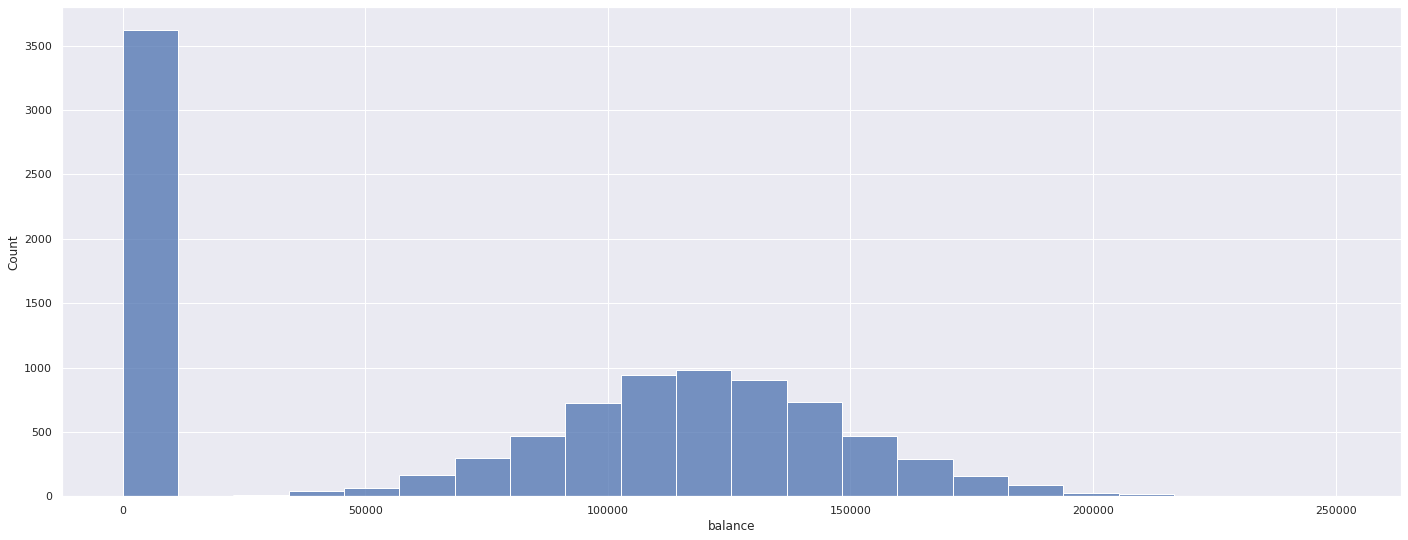

In [29]:
sns.histplot(data=df4['balance'] );

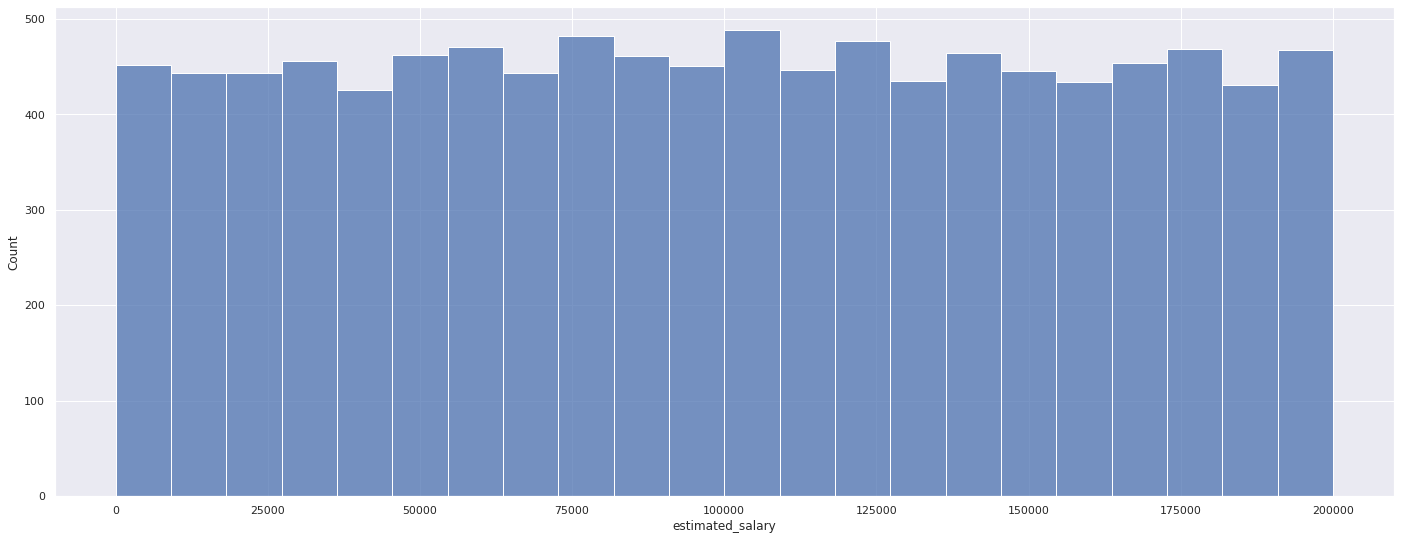

In [30]:
sns.histplot(data=df4['estimated_salary'] );

### 4.1.2. Categorical

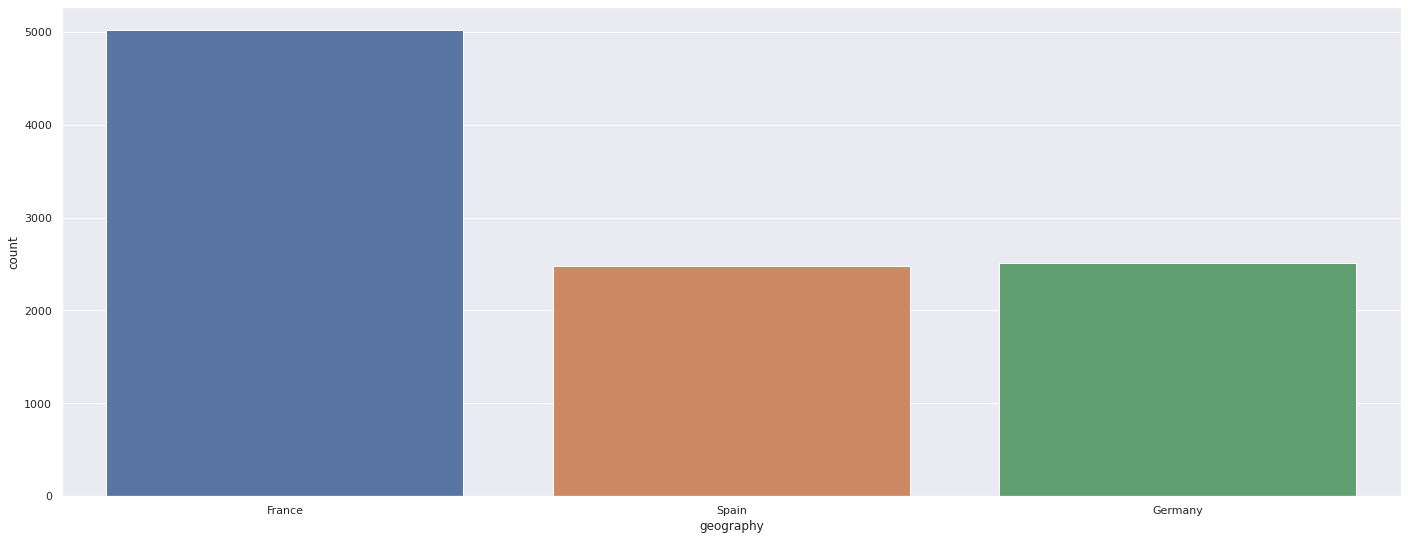

In [31]:
sns.countplot(data=df4, x='geography');

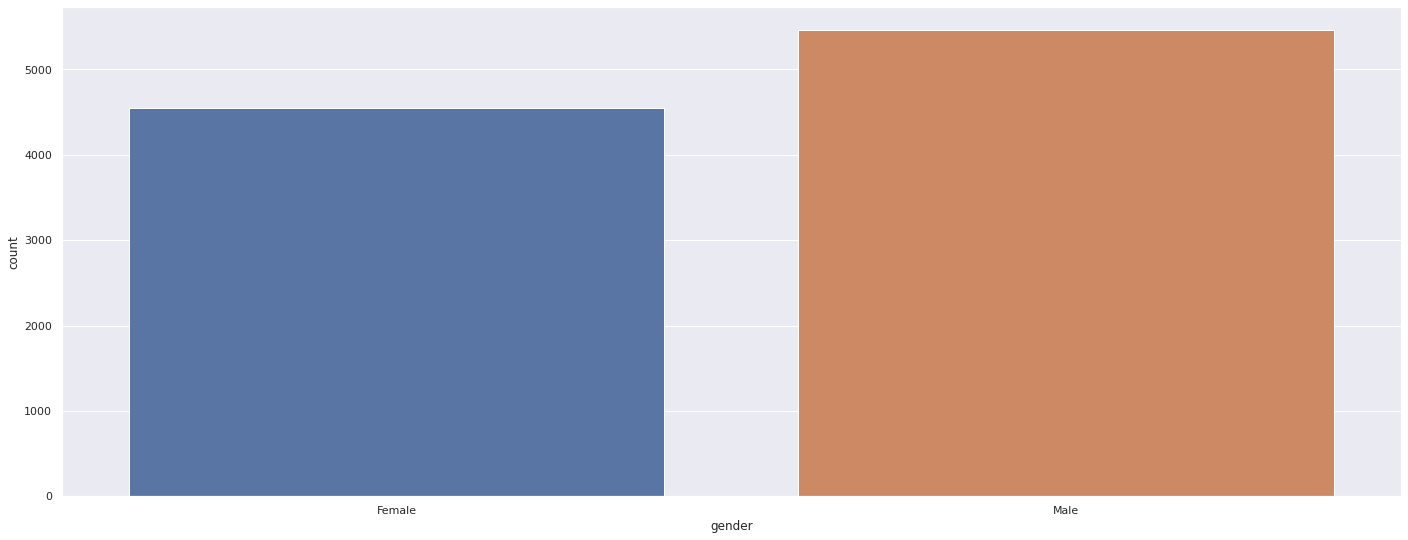

In [32]:
sns.countplot(data=df4, x='gender');

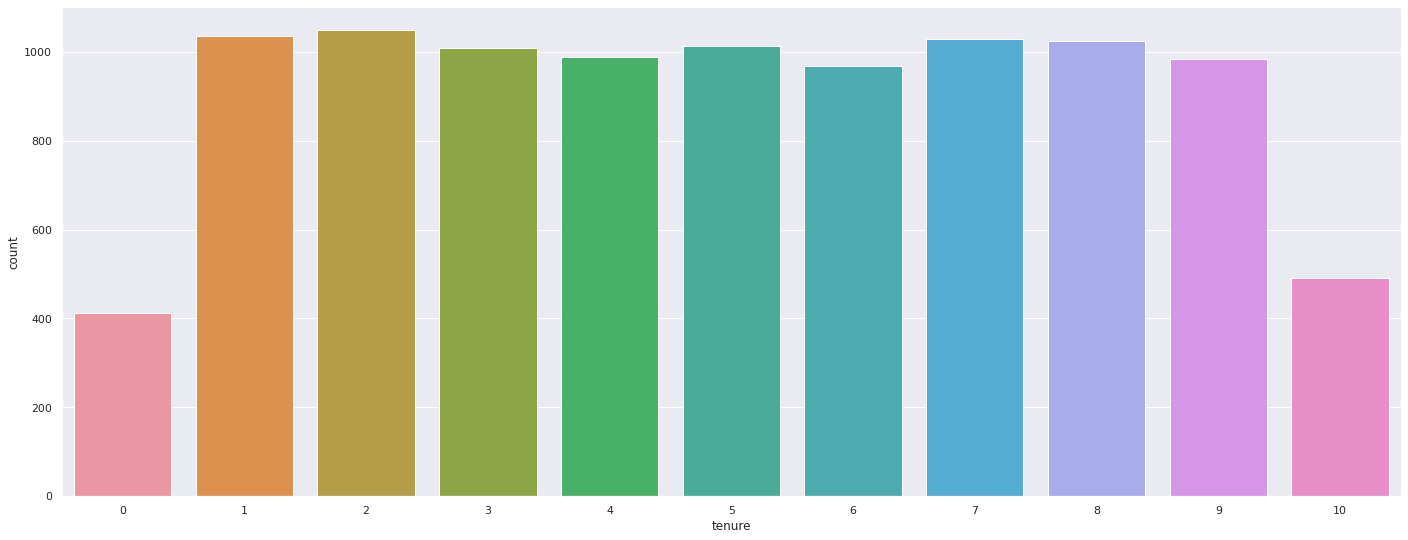

In [33]:
sns.countplot(data=df4, x='tenure');

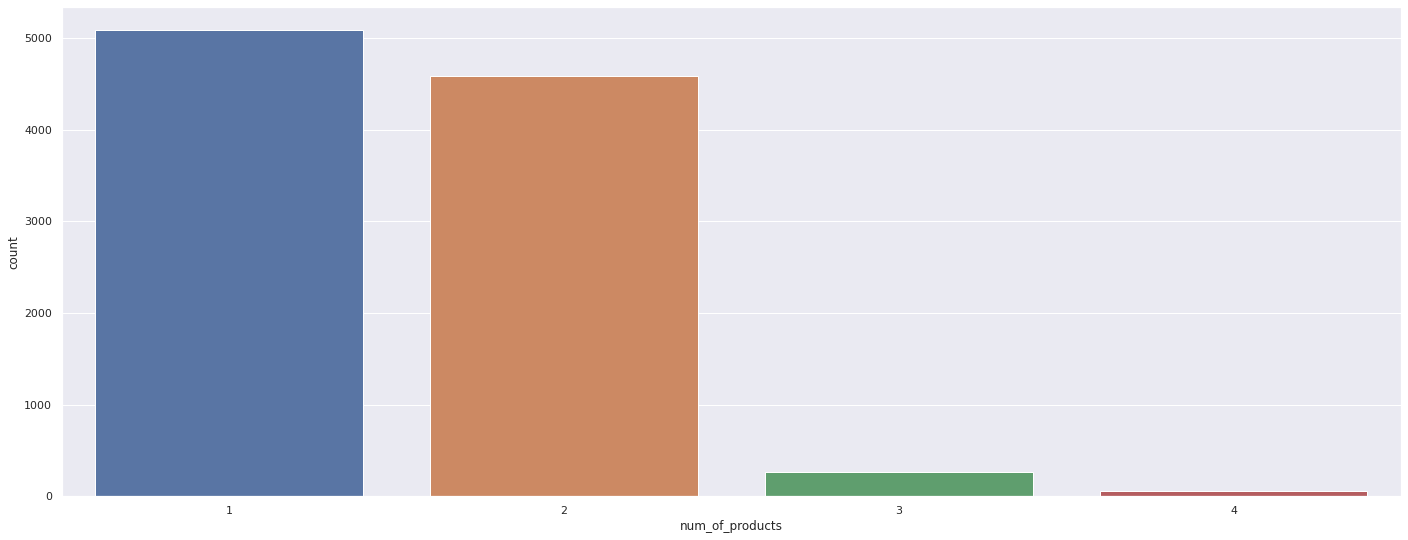

In [34]:
sns.countplot(data=df4, x='num_of_products');

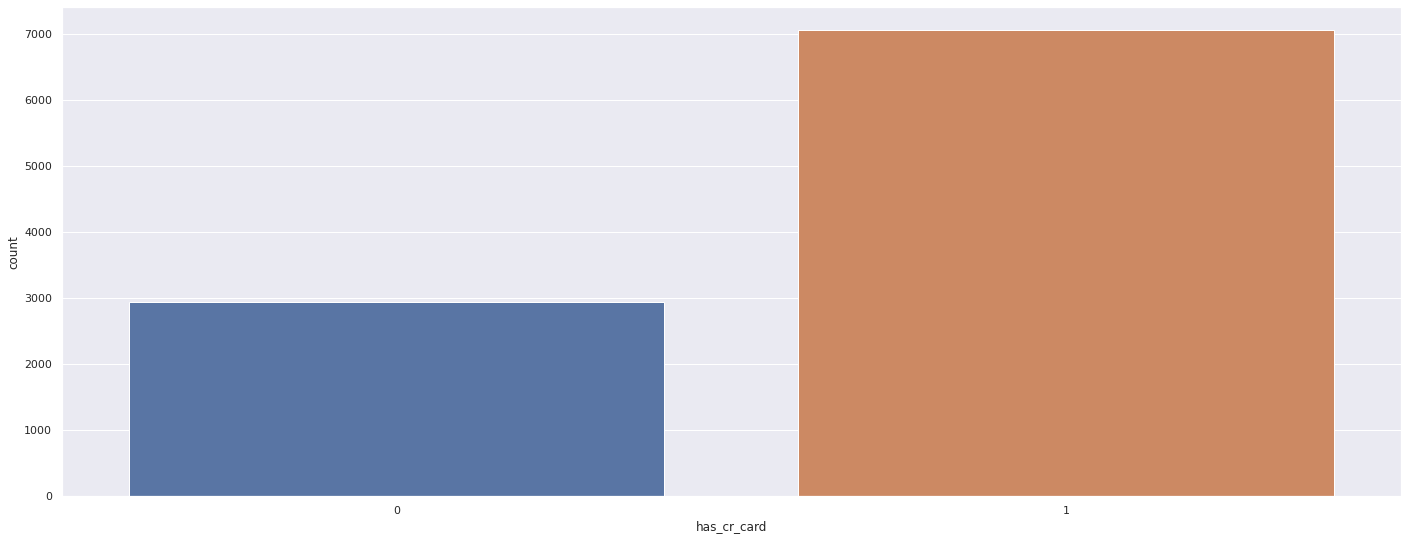

In [35]:
sns.countplot(data=df4, x='has_cr_card');

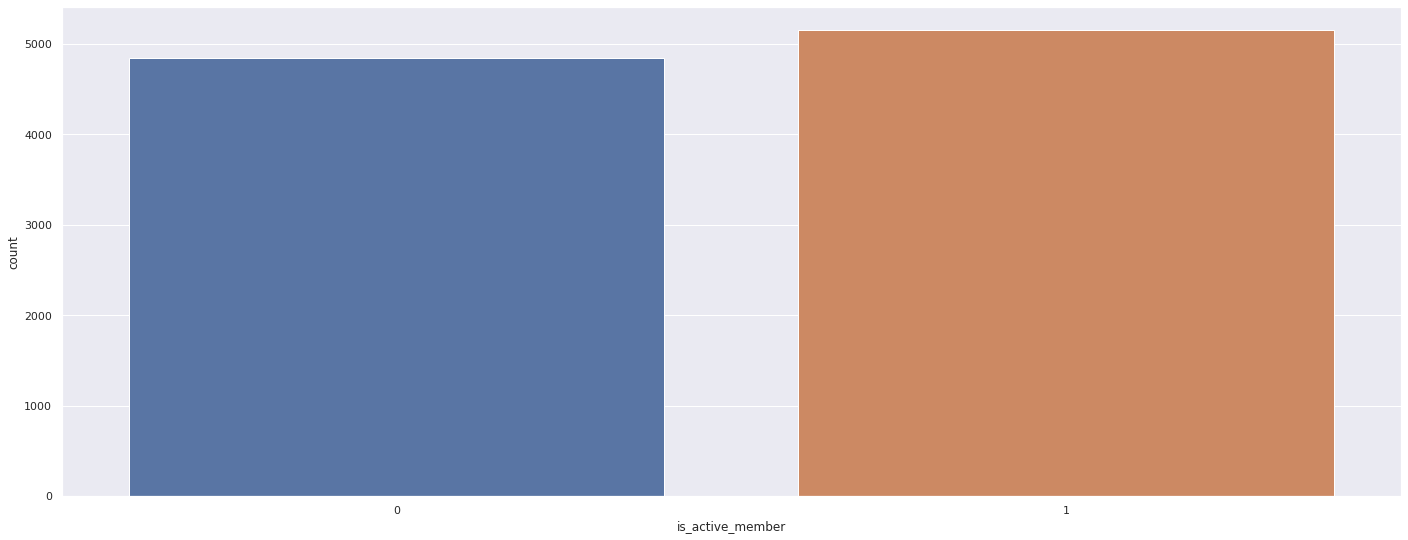

In [36]:
sns.countplot(data=df4, x='is_active_member');

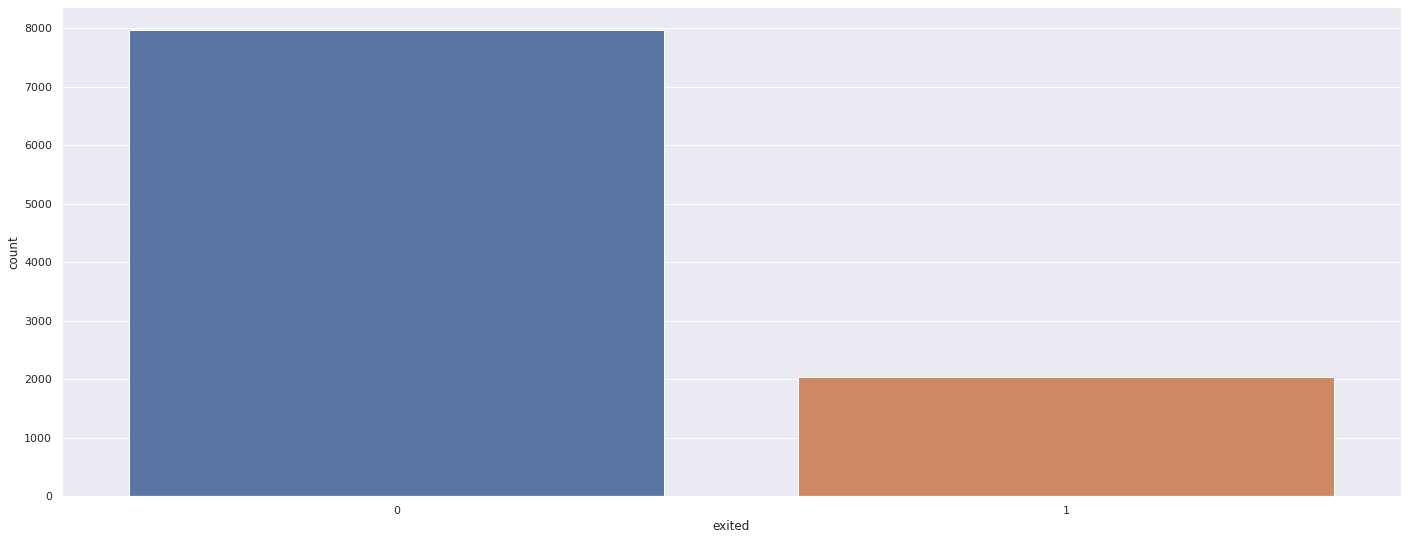

In [37]:
sns.countplot(data=df4, x='exited');

## 4.2. Analysis Bivariate

### credit_score 

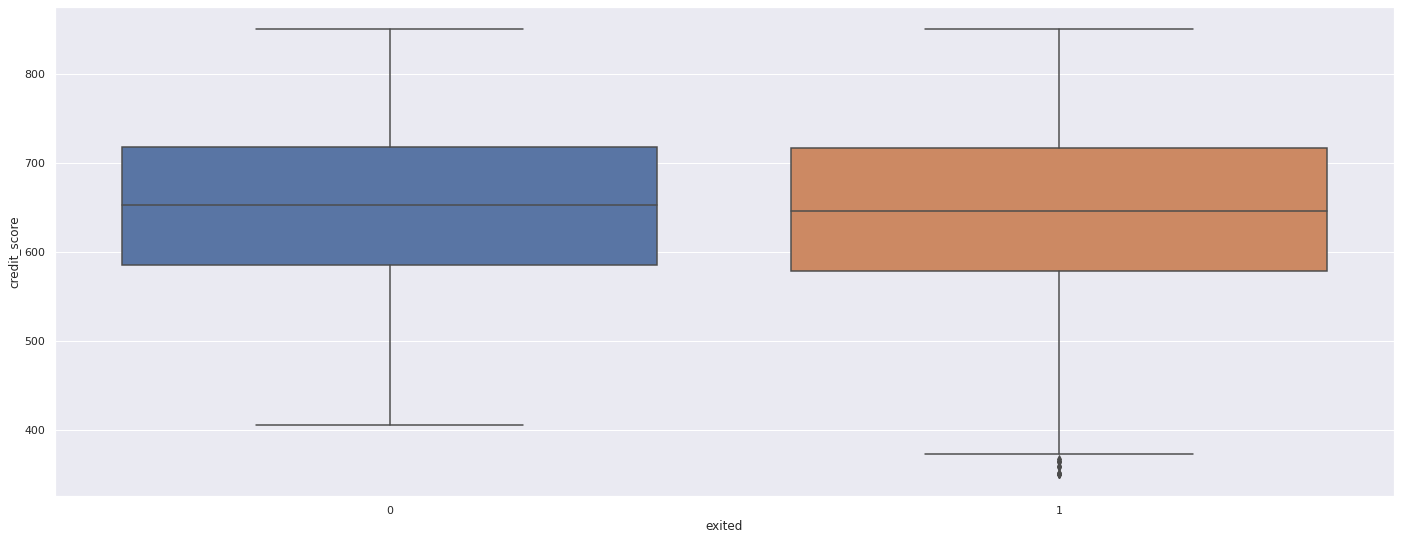

In [38]:
sns.boxplot( x='exited', y='credit_score', data=df4 );

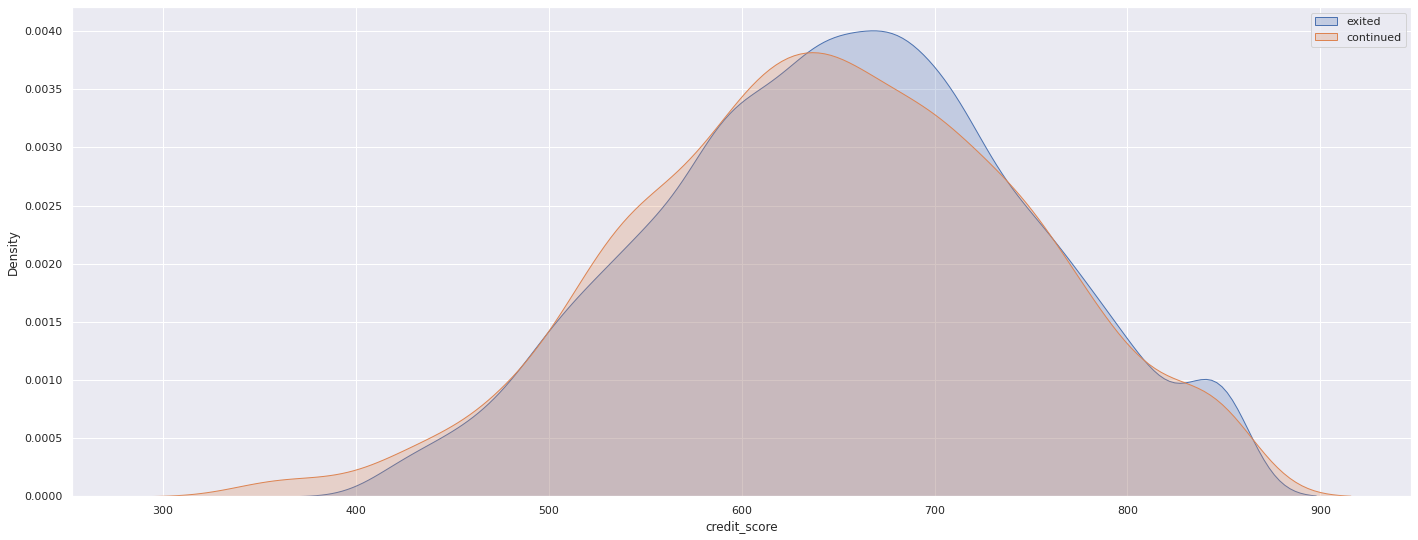

In [39]:
aux1 = df4[df4['exited']==0]
aux2 = df4[df4['exited']==1]

sns.kdeplot(aux1['credit_score'], shade=True, label='exited')
sns.kdeplot(aux2['credit_score'], shade=True, label='continued')
plt.legend();

### geography

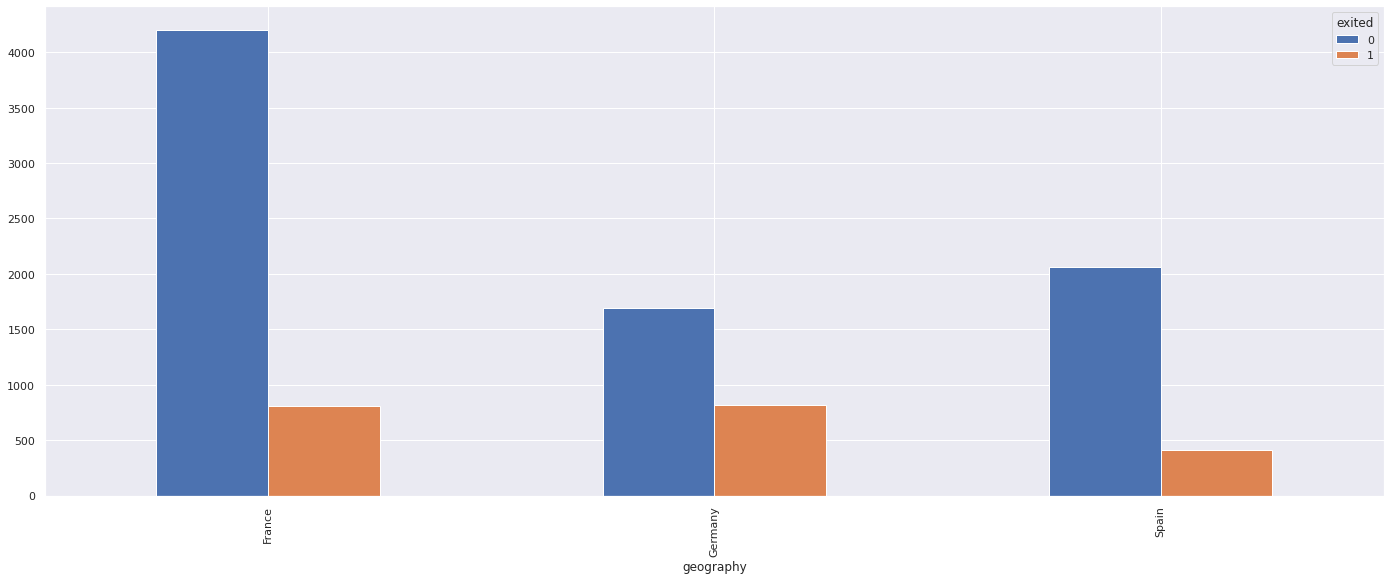

In [40]:
pd.crosstab( df4['geography'], df4['exited'] ).plot(kind='bar');

### gender

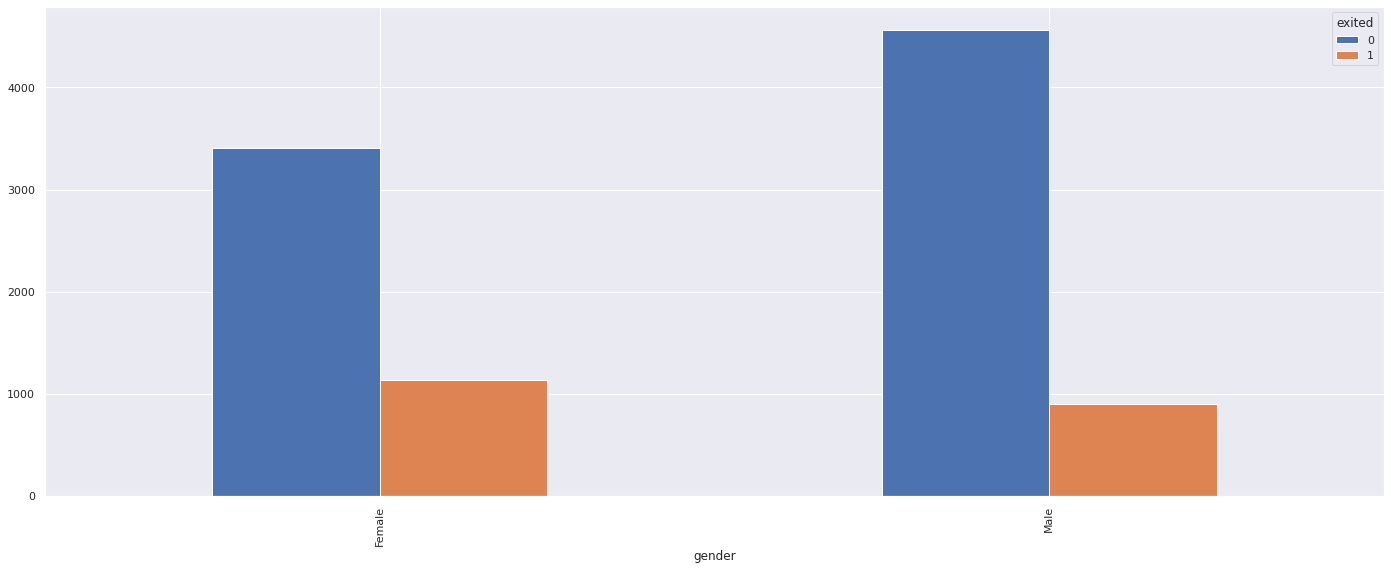

In [41]:
pd.crosstab( df4['gender'], df4['exited'] ).plot(kind='bar');

### age

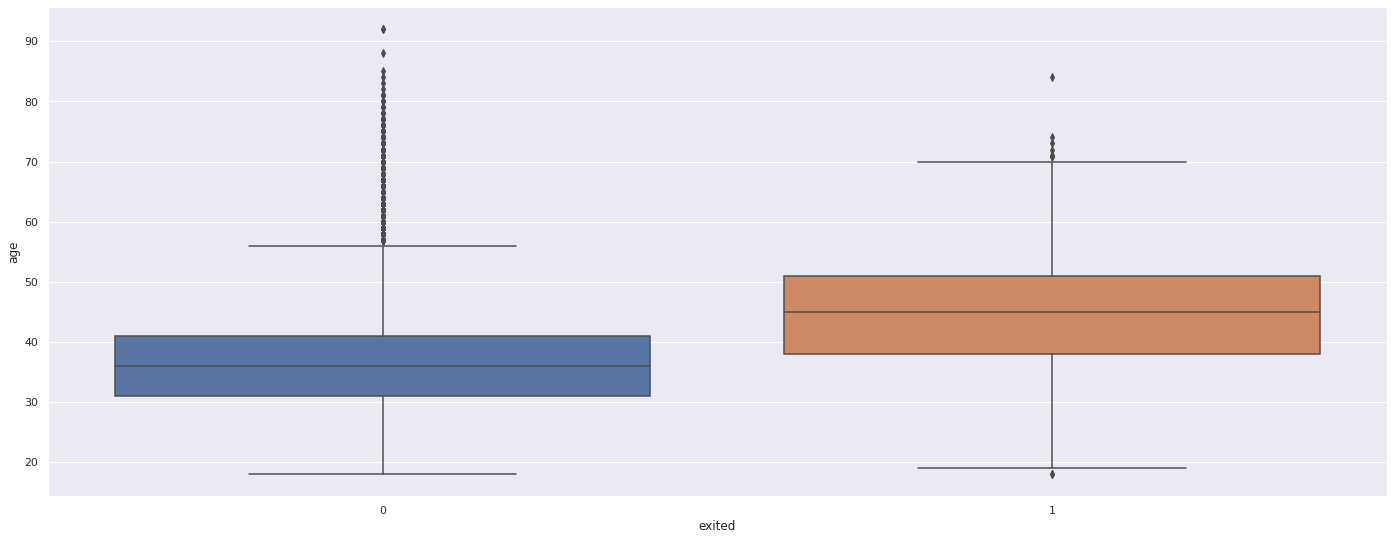

In [42]:
sns.boxplot( x='exited', y='age', data=df4 );

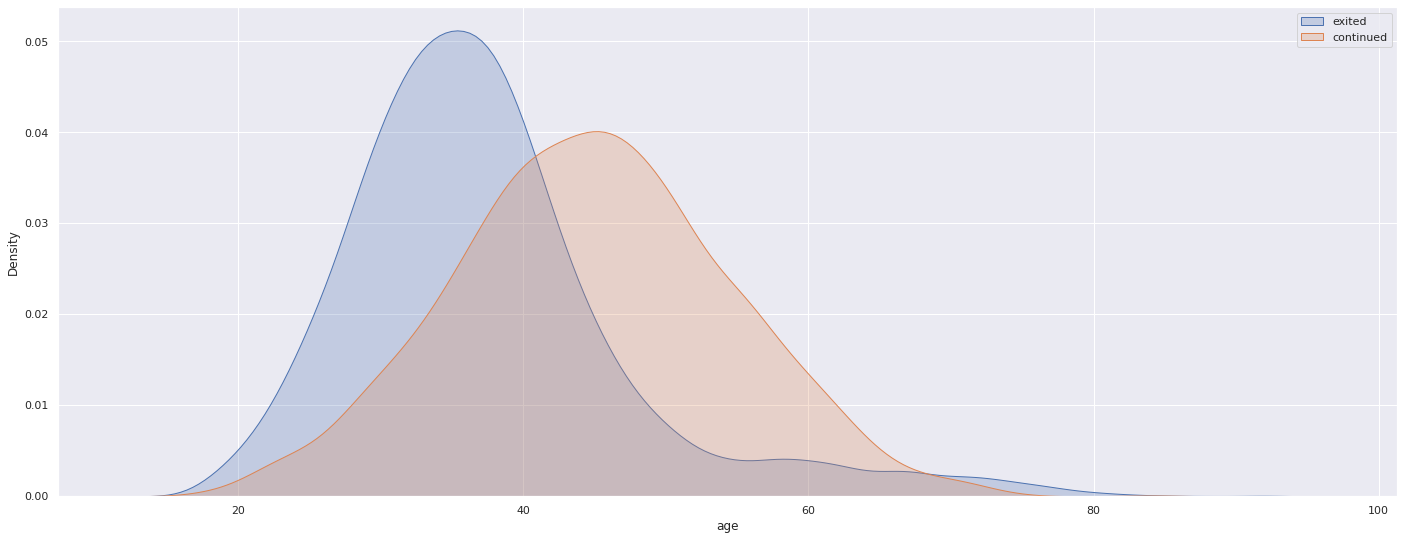

In [43]:
aux1 = df4[df4['exited']==0]
aux2 = df4[df4['exited']==1]

sns.kdeplot(aux1['age'], shade=True, label='exited')
sns.kdeplot(aux2['age'], shade=True, label='continued')
plt.legend();

### tenure

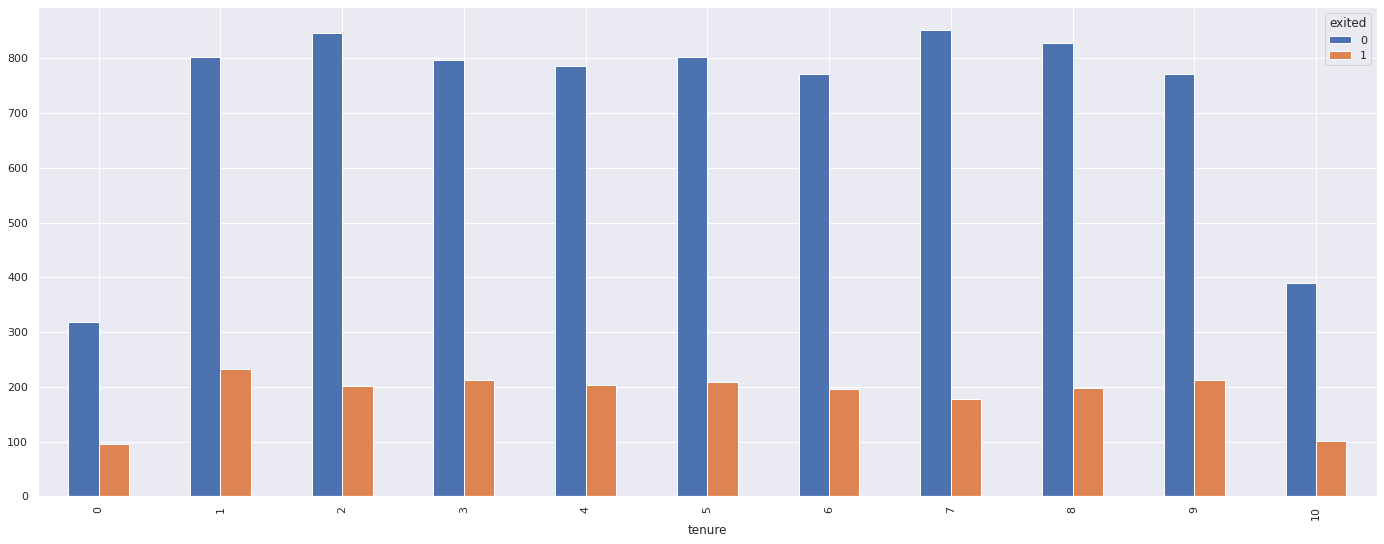

In [44]:
pd.crosstab( df4['tenure'], df4['exited'] ).plot(kind='bar');

### balance

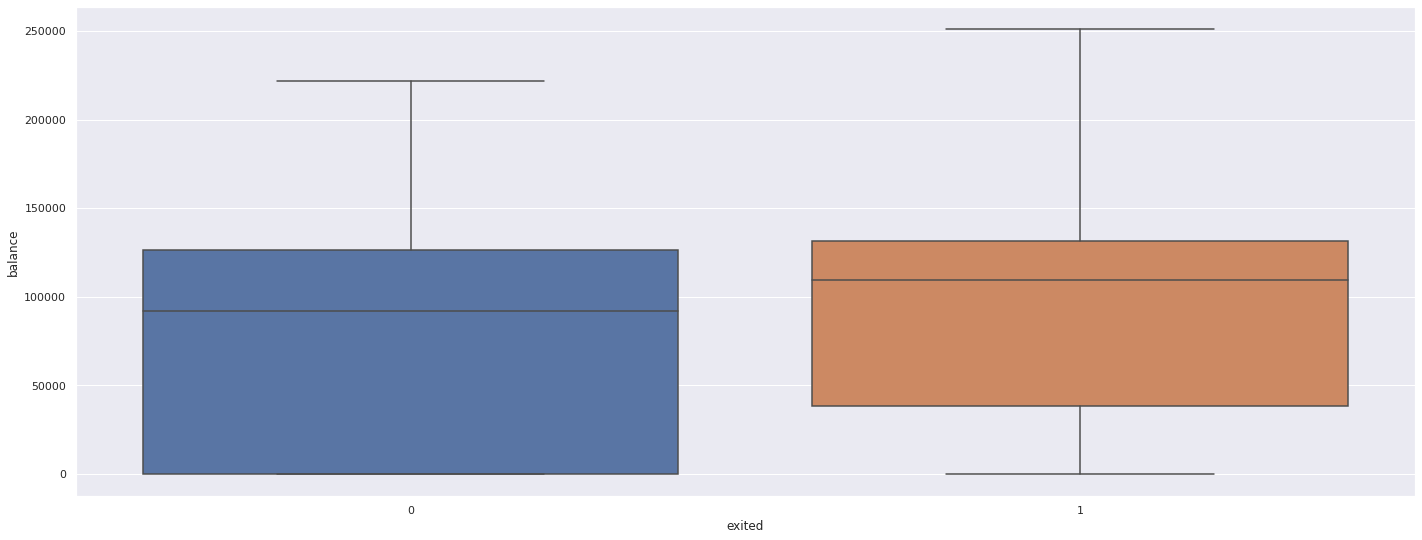

In [45]:
sns.boxplot( x='exited', y='balance', data=df4 );

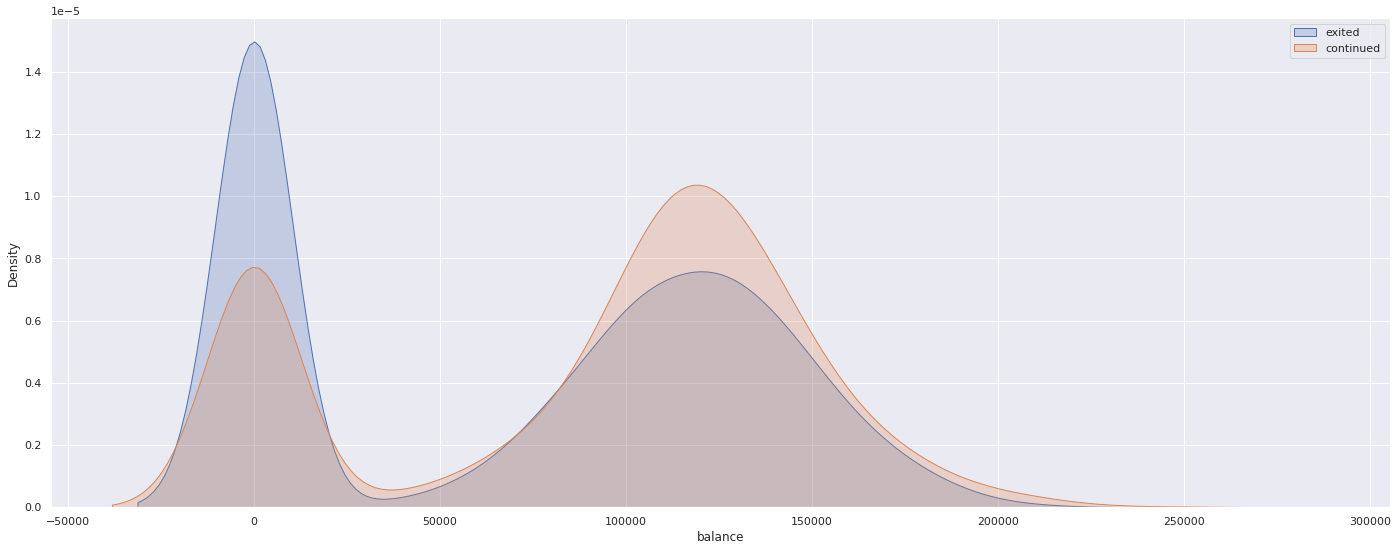

In [46]:
aux1 = df4[df4['exited']==0]
aux2 = df4[df4['exited']==1]

sns.kdeplot(aux1['balance'], shade=True, label='exited')
sns.kdeplot(aux2['balance'], shade=True, label='continued')
plt.legend();

### num_of_products

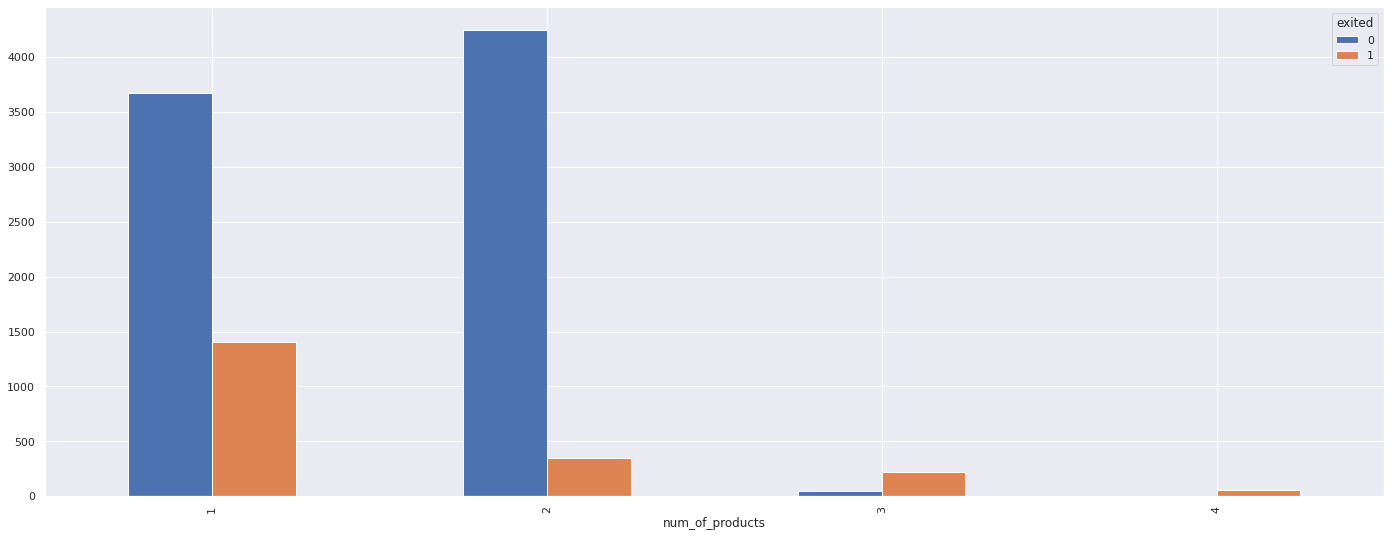

In [47]:
pd.crosstab( df4['num_of_products'], df4['exited'] ).plot(kind='bar');

### has_cr_card

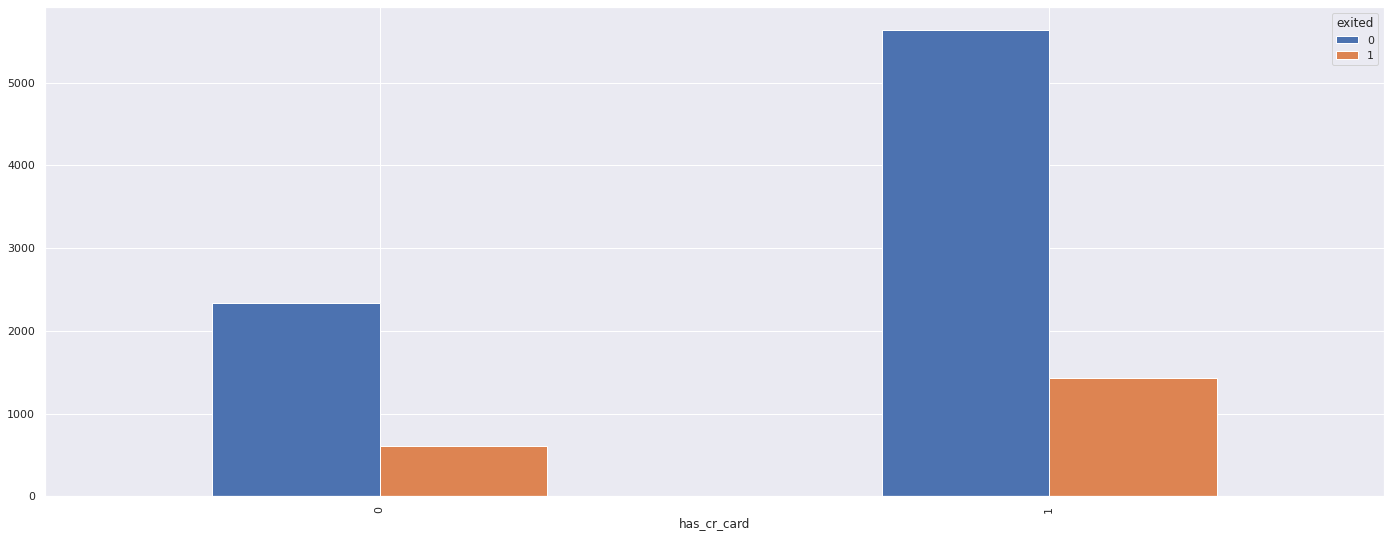

In [48]:
pd.crosstab( df4['has_cr_card'], df4['exited'] ).plot(kind='bar');

### is_active_member

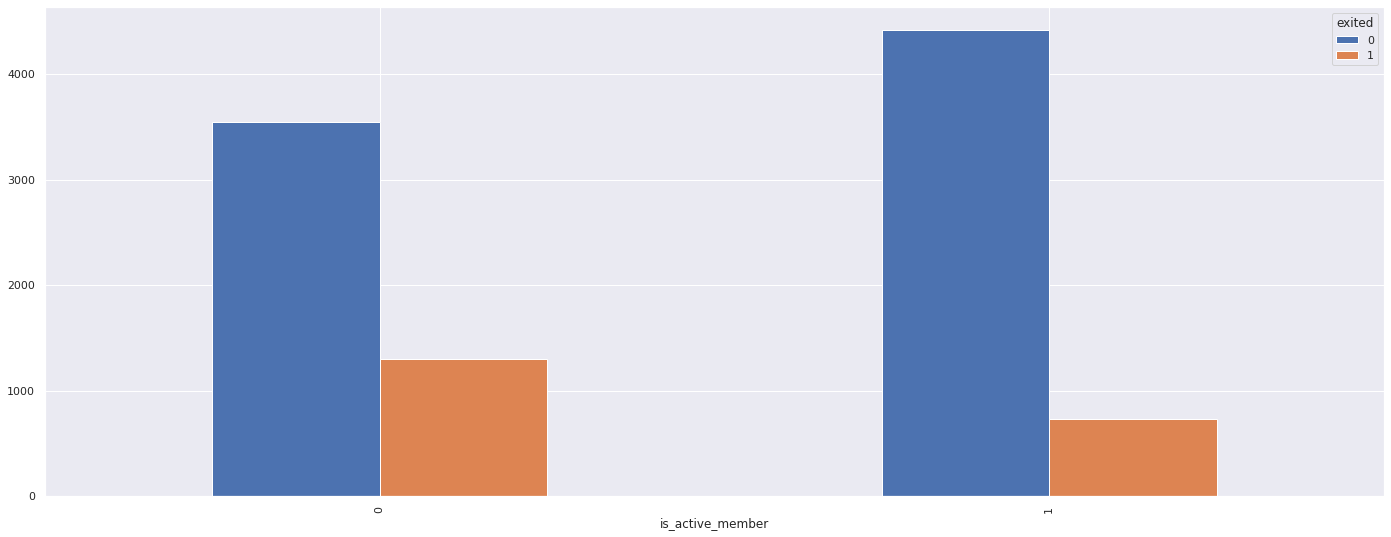

In [49]:
pd.crosstab( df4['is_active_member'], df4['exited'] ).plot(kind='bar');

### estimated_salary

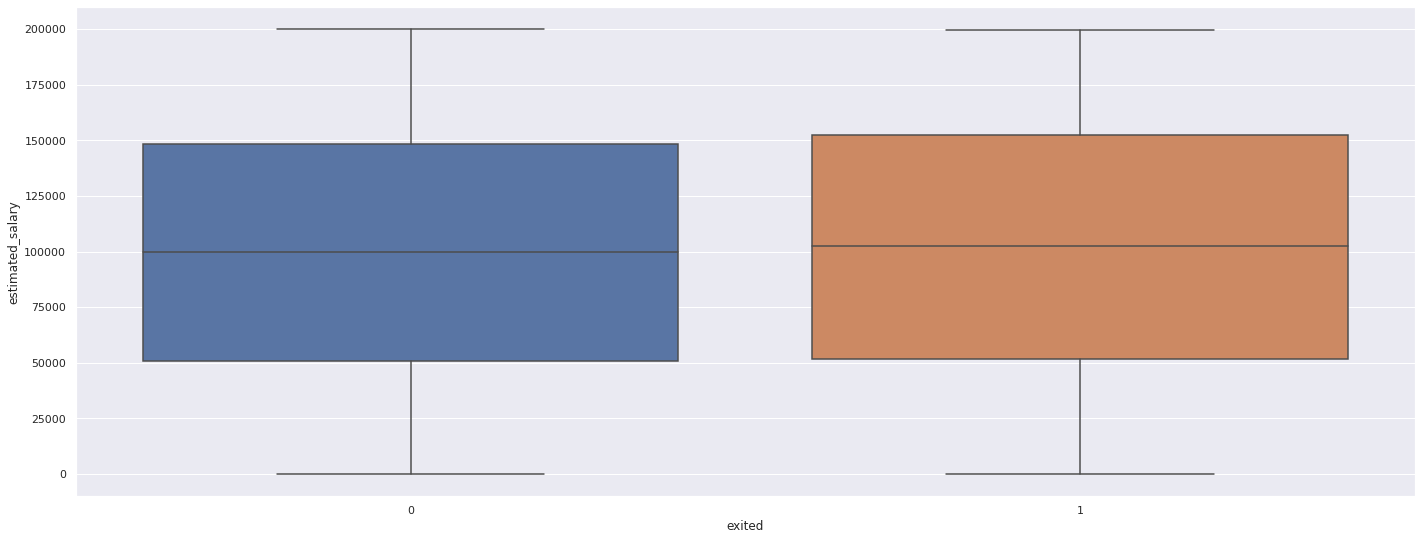

In [50]:
sns.boxplot( x='exited', y='estimated_salary', data=df4 );

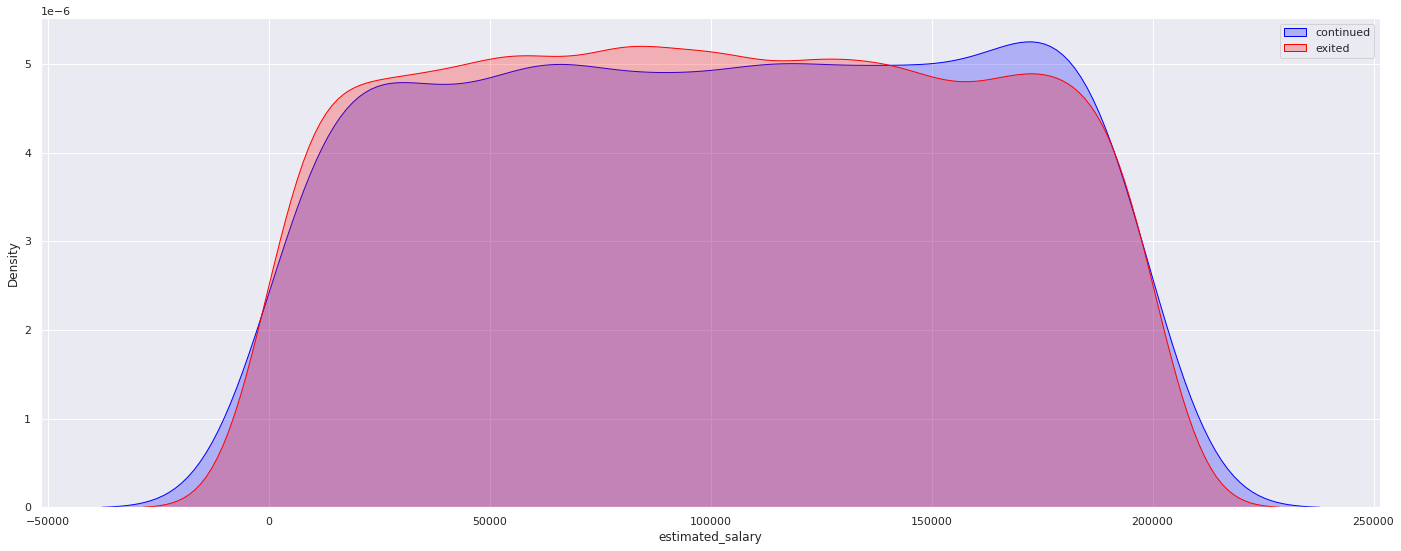

In [51]:
aux1 = df4[df4['exited']==0]
aux2 = df4[df4['exited']==1]

sns.kdeplot(aux2['estimated_salary'], shade=True, label='continued', color='blue')
sns.kdeplot(aux1['estimated_salary'], shade=True, label='exited', color='red')
plt.legend();

### age_group

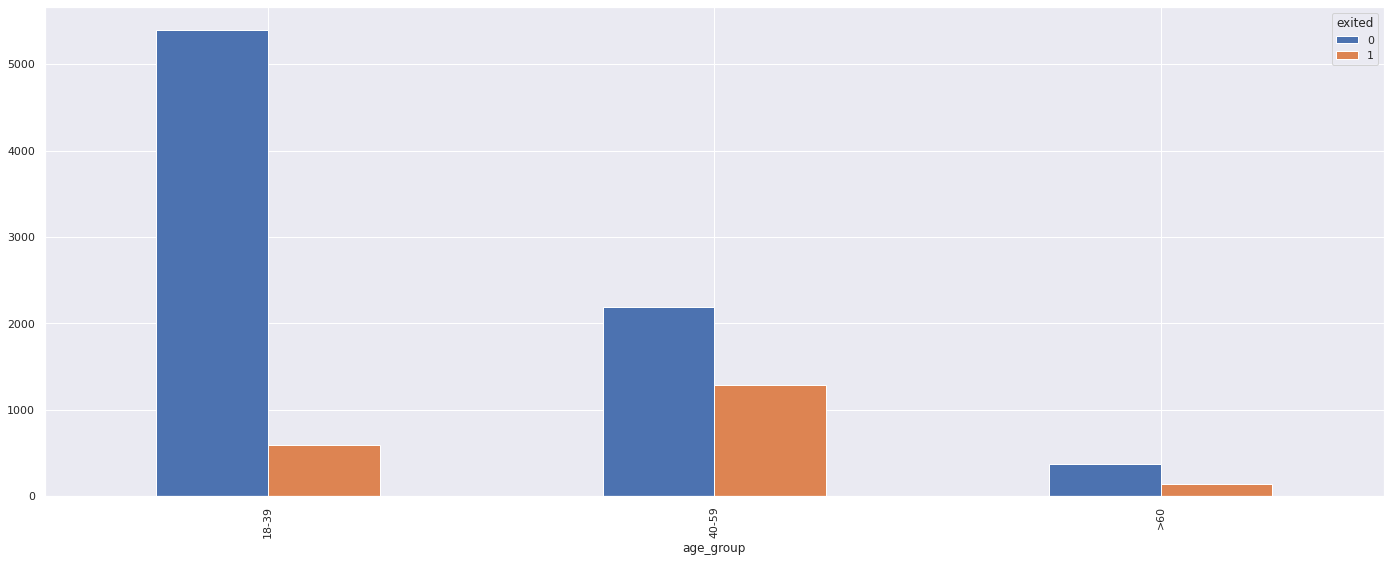

In [52]:
pd.crosstab( df4['age_group'], df4['exited'] ).plot(kind='bar');

## 4.3. Analysis Multivariate

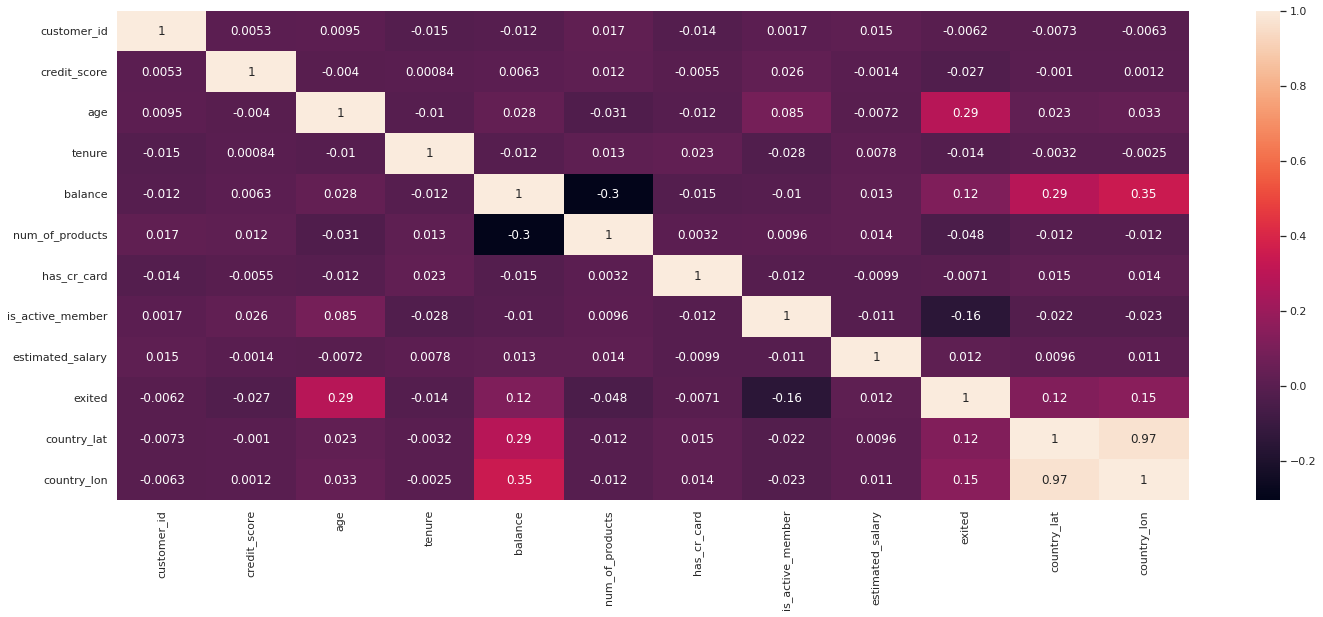

In [53]:
sns.heatmap(df4.corr(), annot=True);

## 4.4. Business Hypotheses

### **H1.** Clientes entre 40 a 59 anos, têm menos chance de abandonar o serviço comparado ao resto da baixo.

**Falso**. Clientes na faixa de 40-59 tem a MAIOR chance de abandonar o serviço.

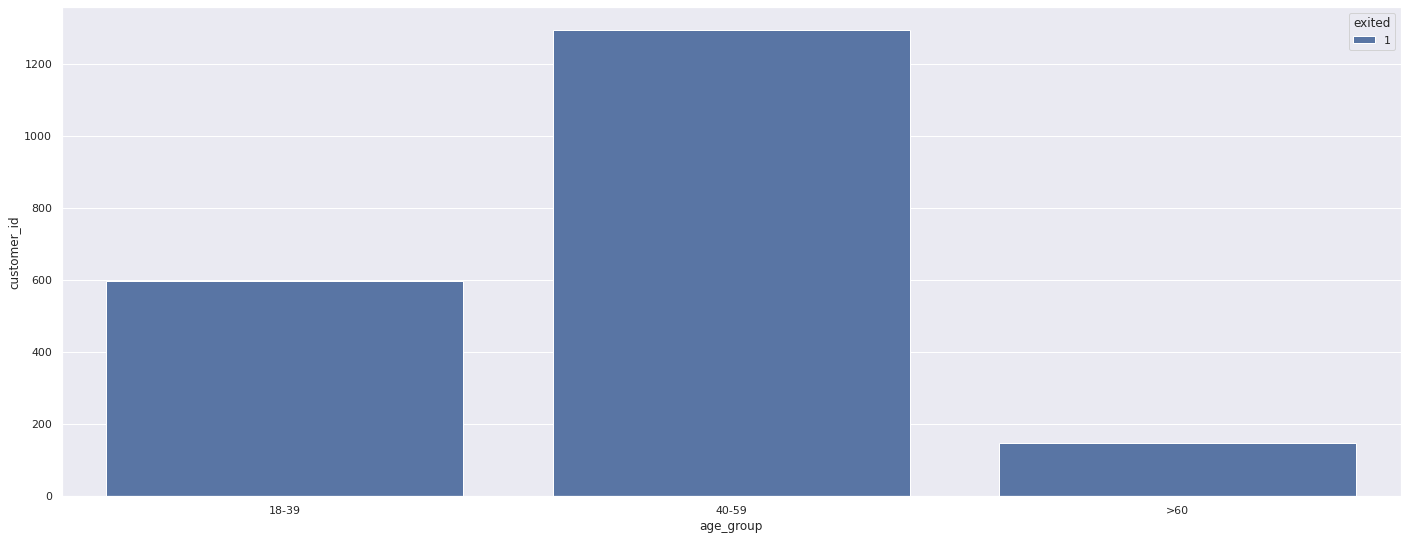

In [54]:
aux1 = df4[df4['exited'] == 1].groupby(['exited', 'age_group'])['customer_id'].count().reset_index()

sns.barplot( x='age_group', y='customer_id', hue='exited',  data=aux1 );

###  **H2.** Cliente com score card abaixo de 400 tem mais chances de abandonar o serviço.
**Verdadeiro**. Na base de dados, todos os clientes abaixo de 400 score card abandonam o serviço.

In [55]:
df4[(df4['credit_score'] <= 400)]['exited'].value_counts()

1    19
Name: exited, dtype: int64

### **H3.** Clientes do sexo feminino tem 60% chance de manter o serviço.
**Verdadeiro**. 74.93% das mulheres mantém o serviço.

74.93% das mulheres mantém o serviço.


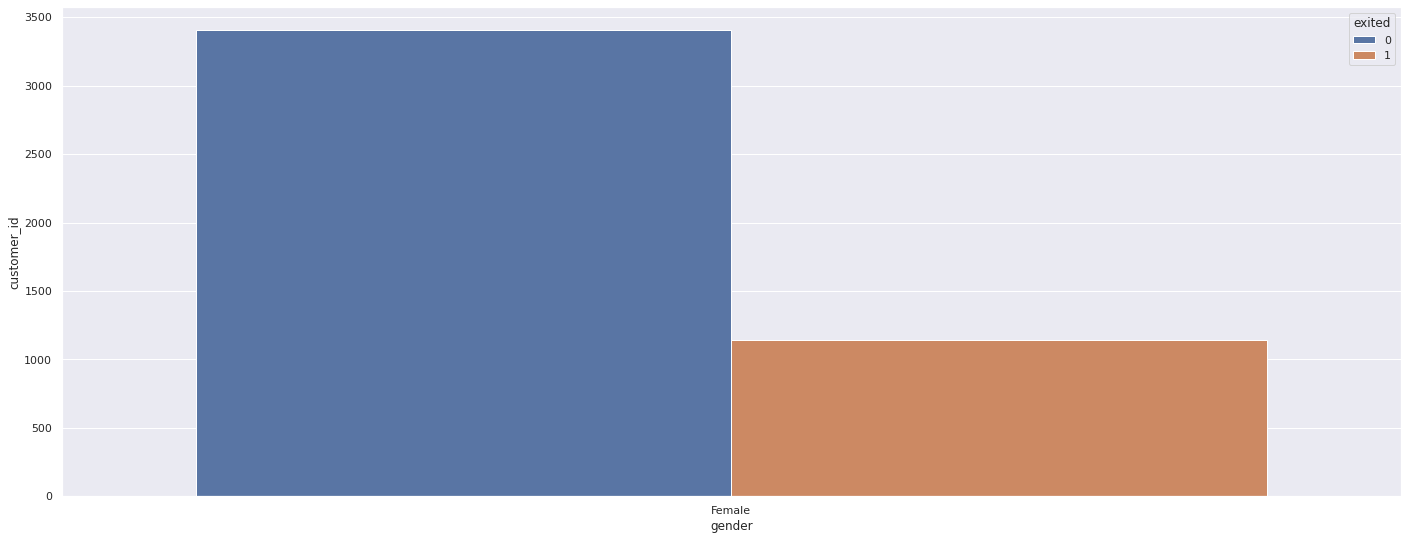

In [56]:
aux = df4[df4['gender'] == 'Female'].groupby(['gender', 'exited'])['customer_id'].count().reset_index()

print( '{}% das mulheres mantém o serviço.'.format( round(aux['customer_id'][0] / aux['customer_id'].sum() * 100, 2) ) )
sns.barplot( x='gender', y='customer_id', hue='exited', data=aux );

### **H4.** Cliente acima de 5 anos usando o  serviço tem 80% de chance de manter o serviço.
**Falso**. Clientes com mais de 5 anos tem 55.42% chance de manter o serviço.

Clientes com mais de 5 anos tem 55.42% chance de manter o serviço.


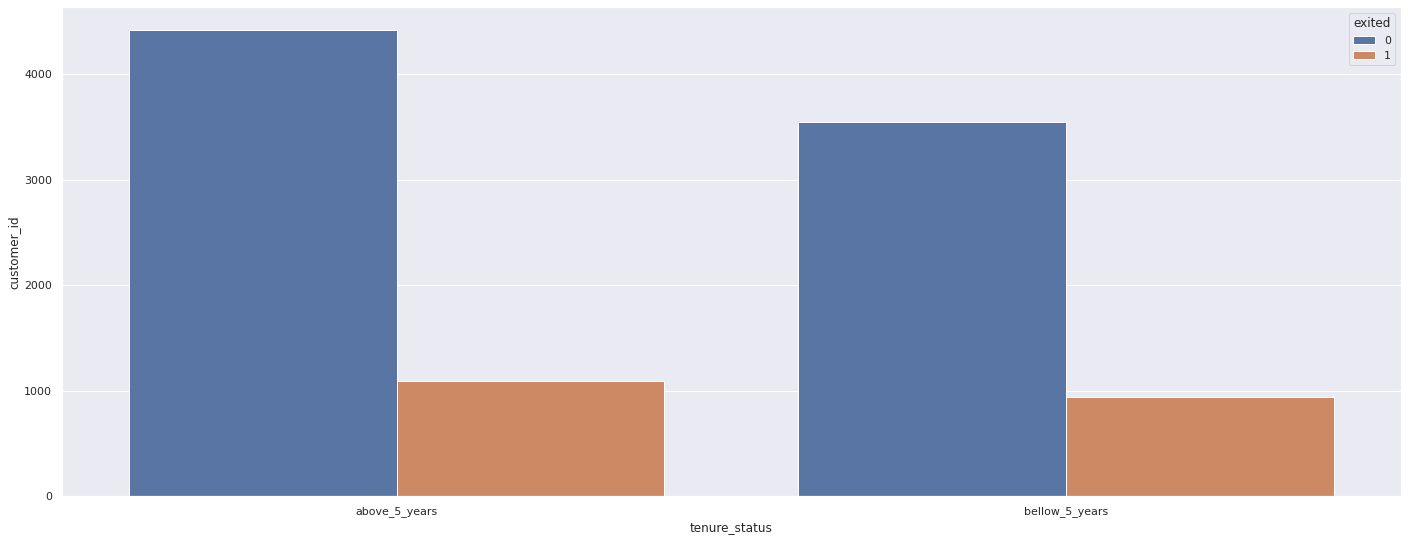

In [57]:
aux = df4.copy()
aux.loc[aux['tenure'] >= 5, 'tenure_status'] = 'above_5_years'
aux.loc[aux['tenure'] < 5, 'tenure_status'] = 'bellow_5_years'

aux1 = aux.groupby( ['tenure_status', 'exited'] )['customer_id'].count().reset_index()

per_above_5_years = round((aux1['customer_id'][0]) / ((aux1['customer_id'][0]) + (aux1['customer_id'][2]) ) * 100, 2)

print( 'Clientes com mais de 5 anos tem {}% chance de manter o serviço.'.format( per_above_5_years ) ) 

sns.barplot( x='tenure_status', y='customer_id', hue='exited', data=aux1 );

### **H5.** Clientes que têm salário acima da média, têm mais chances de abandonar o serviço.
**Verdadeiro**. Clientes que tem o salario acima da média, tem 49.79% de abandonar o serviço.

Clientes que tem o salario acima da média, tem 49.79% de abandonar o serviço


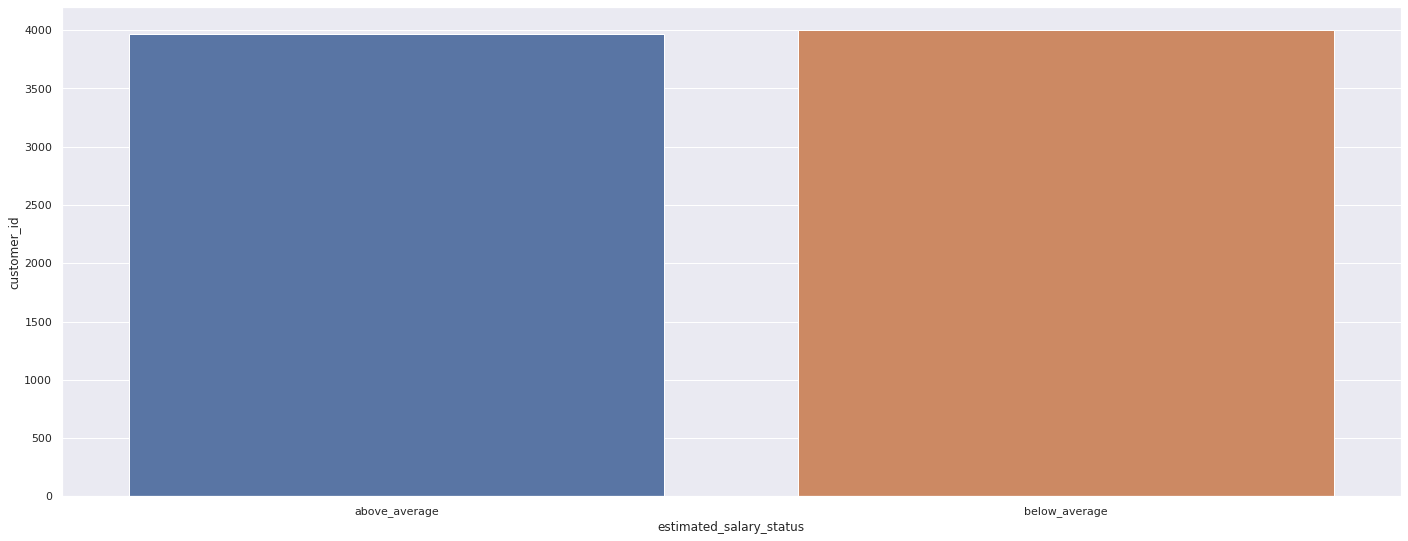

In [58]:
aux = df4.copy()

avg_salary = aux['estimated_salary'].mean()
aux.loc[aux['estimated_salary'] > avg_salary, 'estimated_salary_status'] = 'above_average'
aux.loc[aux['estimated_salary'] <= avg_salary, 'estimated_salary_status'] = 'below_average'

aux1 = aux.loc[aux['exited'] == 0, :].groupby( 'estimated_salary_status' )['customer_id'].count().reset_index()

estimated_salary_above_average = round(aux1['customer_id'][0] / (aux1['customer_id'][0] + aux1['customer_id'][1]) * 100, 2)
print( 'Clientes que tem o salario acima da média, tem {}% de abandonar o serviço'.format(estimated_salary_above_average) )


sns.barplot( x='estimated_salary_status', y='customer_id', data=aux1 );

### **H6.** Clientes que não têm dinheiro em saldo têm mais chances de abandonar o serviço.
**Falso.** Cliente que não tem dinheiro em saldo, tem menos chance de abanadonar o serviço.

In [59]:
aux = df4.groupby( ['balance_status', 'exited'] )['customer_id'].count().reset_index()
aux[aux['exited'] == 1]['customer_id'].pct_change()

1       NaN
3   -0.6747
Name: customer_id, dtype: float64

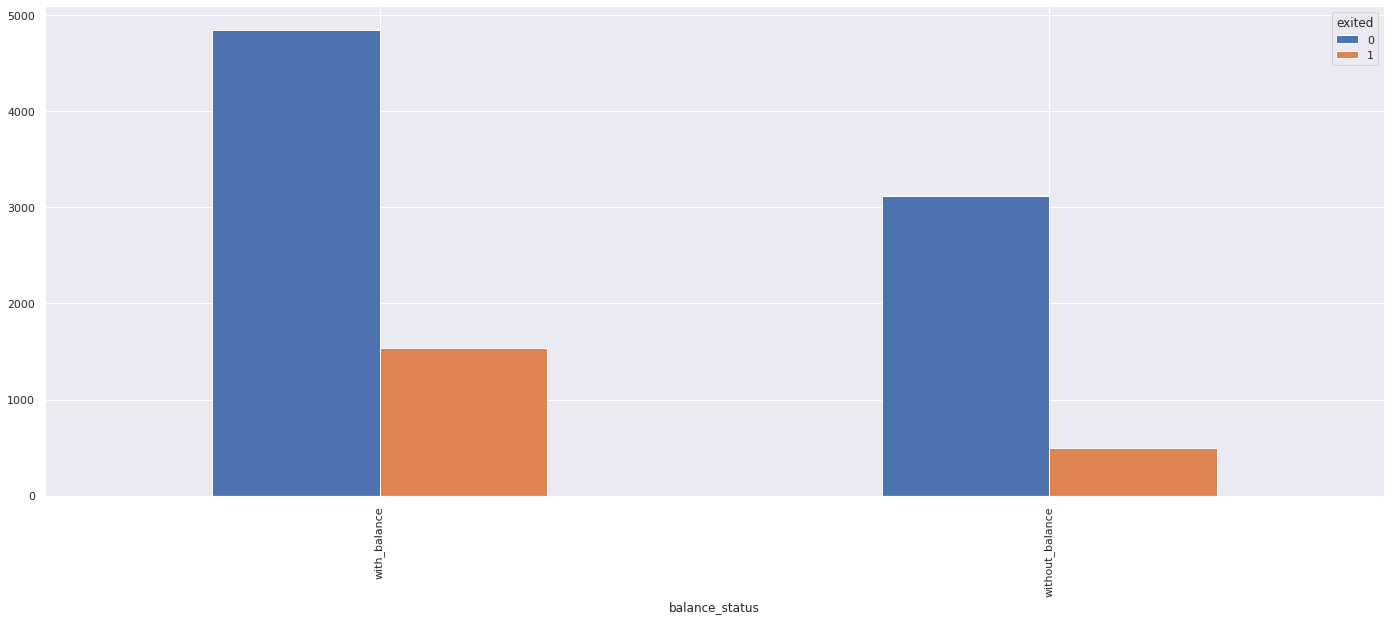

In [60]:
pd.crosstab(df4['balance_status'], df4['exited']).plot.bar();

### **H7.** Clientes residentes na residentes na Espanha tem mais chances de MANTER O SERVIÇO em comparação comparado aos outros países.
**Verdadeiro**. Cliente que residem na Espanha tem mais chances de MANTER O SERVIÇO.

In [61]:
aux = df4.groupby( ['geography', 'exited'] )['customer_id'].count().reset_index()
aux = aux[aux['exited'] == 1]

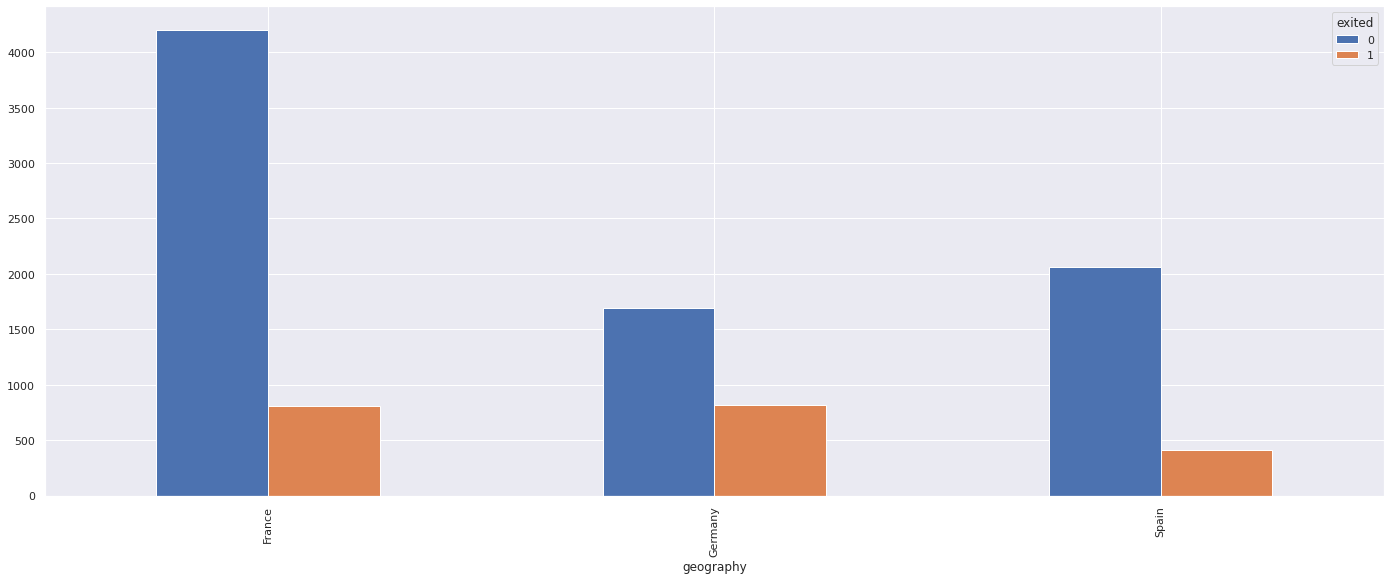

In [62]:
pd.crosstab( df4['geography'], df4['exited'] ).plot.bar();

### **H8.** Clientes que possuem cartão de crédito, tem mais chances de MANTER O SERVIÇO dos que não tem.
**Verdadeiro**.  Clientes  que possuem cartão, tem 70.71% de manter o serviço

Clientes  que possuem cartão, tem 70.71% de manter o serviço


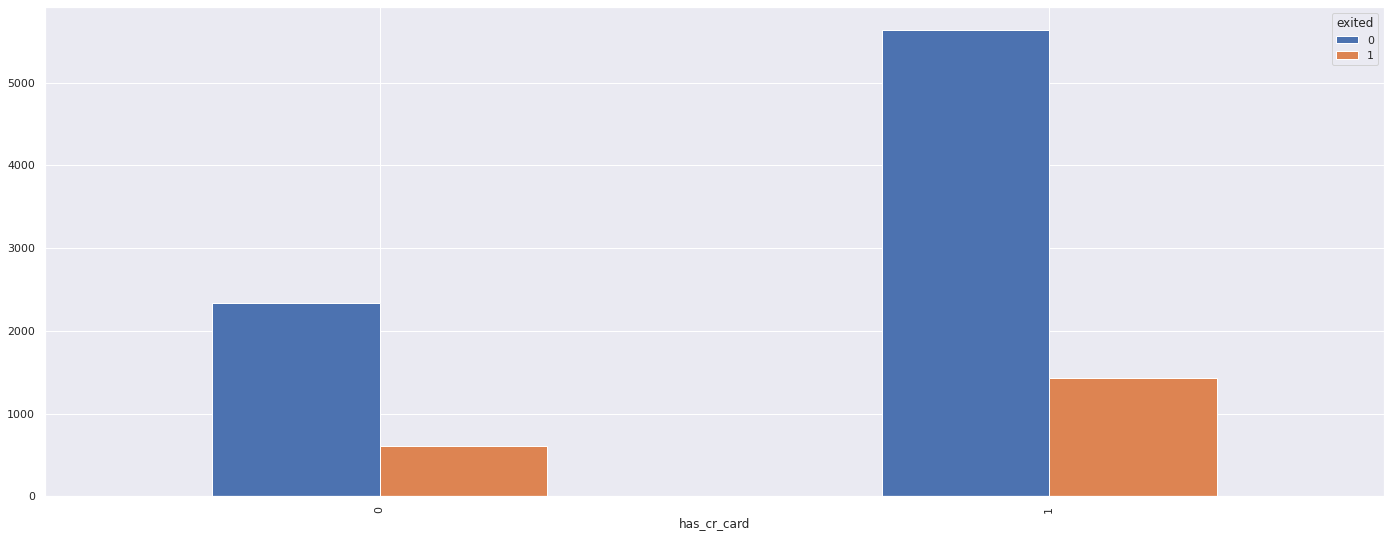

In [63]:
aux = df4[df4['exited'] == 0]

aux1 = aux[aux['has_cr_card'] == 0]
aux2 = aux[aux['has_cr_card'] == 1]

prc_has_cr_card = round(aux2['customer_id'].count() / (aux1['customer_id'].count() + aux2['customer_id'].count()) * 100, 2 )

print( 'Clientes  que possuem cartão, tem {}% de manter o serviço'.format(prc_has_cr_card) )

pd.crosstab( df4['has_cr_card'], df4['exited'] ).plot.bar();

# 5.0. Data Preprocessing

In [64]:
X = df4.drop(['exited', 'customer_id'], axis=1)
y = df4['exited'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     train_size=0.8, 
                                                     random_state=42, 
                                                     shuffle=True, 
                                                     stratify=None)

df5 = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

## 5.1. Standardization

In [65]:
ss_credit_score = pp.StandardScaler()

# credit_score
df5['credit_score'] = ss_credit_score.fit_transform( df5[['credit_score']].values )

## 5.2. Scale

In [66]:
# age
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# balance
mms_balance = pp.MinMaxScaler()
df5['balance'] = mms_age.fit_transform( df5[['balance']].values )

# estimated_salary
mms_estimated_salary = pp.MinMaxScaler()
df5['estimated_salary'] = mms_estimated_salary.fit_transform( df5[['estimated_salary']].values )

# country_lat
mms_country_lat = pp.MinMaxScaler()
df5['country_lat'] = mms_country_lat.fit_transform( df5[['country_lat']].values )

# country_lon
mms_country_lon = pp.MinMaxScaler()
df5['country_lon'] = mms_country_lon.fit_transform( df5[['country_lon']].values )

## 5.3. Transformartion



In [67]:
# target encode - geography
target_encode_geography = df5.groupby('geography')['exited'].mean()
df5.loc[:, 'geography'] = df5.loc[:, 'geography'].map(target_encode_geography)

# target encode - gender
target_encode_gender = df5.groupby('gender')['exited'].mean()
df5.loc[:, 'gender'] = df5.loc[:, 'gender'].map(target_encode_gender)

# target encode - age_group
target_encode_age_group = df5.groupby('age_group')['exited'].mean()
df5.loc[:, 'age_group'] = df5.loc[:, 'age_group'].map(target_encode_age_group)

# target encode - balance_status
target_encode_balance_status = df5.groupby('balance_status')['exited'].mean()
df5.loc[:, 'balance_status'] = df5.loc[:, 'balance_status'].map(target_encode_balance_status)

# num_of_products
target_encode_num_of_products = df5.groupby('num_of_products')['exited'].mean()
df5.loc[:, 'num_of_products'] = df5.loc[:, 'num_of_products'].map(target_encode_num_of_products)

# target encode - tenure
target_encode_tenure = df5.groupby('tenure')['exited'].mean()
df5.loc[:, 'tenure'] = df5.loc[:, 'tenure'].map(target_encode_tenure)

# target encode - has_cr_card
target_encode_has_cr_card = df5.groupby('has_cr_card')['exited'].mean()
df5.loc[:, 'has_cr_card'] = df5.loc[:, 'has_cr_card'].map(target_encode_has_cr_card)

# target encode - is_active_member
target_encode_is_active_member = df5.groupby('is_active_member')['exited'].mean()
df5.loc[:, 'is_active_member'] = df5.loc[:, 'is_active_member'].map(target_encode_is_active_member)

## 5.4. Validation

In [68]:
## 5.1. Standardization
ss_credit_score = pp.StandardScaler()

# credit_score
X_val.loc[:, 'credit_score'] = ss_credit_score.fit_transform( X_val[['credit_score']].values )

## 5.2. Scale
# age
X_val.loc[:, 'age'] = mms_age.fit_transform( X_val[['age']].values )

# balance
X_val.loc[:, 'balance'] = mms_age.fit_transform( X_val[['balance']].values )

# estimated_salary
X_val.loc[:, 'estimated_salary'] = mms_estimated_salary.fit_transform( X_val[['estimated_salary']].values )

# country_lat
X_val.loc[:, 'country_lat'] = mms_country_lat.fit_transform( X_val[['country_lat']].values )

# country_lon
X_val.loc[:, 'country_lon'] = mms_country_lon.fit_transform( X_val[['country_lon']].values )

## 5.3. Transformartion
# target encode - geography
X_val.loc[:, 'geography'] = X_val.loc[:, 'geography'].map(target_encode_geography)

# target encode - gender
X_val.loc[:, 'gender'] = X_val.loc[:, 'gender'].map(target_encode_gender)

# target encode - age_group
X_val.loc[:, 'age_group'] = X_val.loc[:, 'age_group'].map(target_encode_age_group)

# target encode - balance_status
X_val.loc[:, 'balance_status'] = X_val.loc[:, 'balance_status'].map(target_encode_balance_status)

# num_of_products
X_val.loc[:, 'num_of_products'] = X_val.loc[:, 'num_of_products'].map(target_encode_num_of_products)

# target encode - tenure
X_val.loc[:, 'tenure'] = X_val.loc[:, 'tenure'].map(target_encode_tenure)

# target encode - has_cr_card
X_val.loc[:, 'has_cr_card'] = X_val.loc[:, 'has_cr_card'].map(target_encode_has_cr_card)

# target encode - is_active_member
X_val.loc[:, 'is_active_member'] = X_val.loc[:, 'is_active_member'].map(target_encode_is_active_member)

/home/cid/.pyenv/versions/3.8.0/envs/churn-prediction/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/cid/.pyenv/versions/3.8.0/envs/churn-prediction/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/cid/.pyenv/versions/3.8.0/envs/churn-prediction/lib/python3.8/site-packa

# 6.0. Feature Selection

In [69]:
X_train = df5.drop('exited', axis=1)
y_train = df5['exited']

## 6.1. Feature Importance

In [70]:
forest = ensemble.RandomForestClassifier(n_estimators=1000, 
                                           criterion='gini', 
                                           max_depth=10, 
                                           min_samples_split=2, 
                                           min_samples_leaf=1, 
                                           min_weight_fraction_leaf=0.0, 
                                           max_features='auto', 
                                           max_leaf_nodes=None, 
                                           min_impurity_decrease=0.0, 
                                           min_impurity_split=None, 
                                           bootstrap=True, 
                                           oob_score=False, 
                                           n_jobs=None, 
                                           random_state=42, 
                                           verbose=0, 
                                           warm_start=False, 
                                           class_weight=None, 
                                           ccp_alpha=0.0, 
                                           max_samples=None)




forest.fit( X_train, y_train )

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

In [71]:
df_importance = pd.DataFrame(data=forest.feature_importances_, index=X_train.columns.tolist()).reset_index()
df_importance.columns = ['feature', 'importance']
df_importance = df_importance.sort_values('importance', ascending=False)

df_importance

,feature,importance
6,num_of_products,0.2164
3,age,0.2140
12,age_group,0.0990
5,balance,0.0953
0,credit_score,0.0805
9,estimated_salary,0.0797
8,is_active_member,0.0636
4,tenure,0.0465
1,geography,0.0200
11,country_lon,0.0199


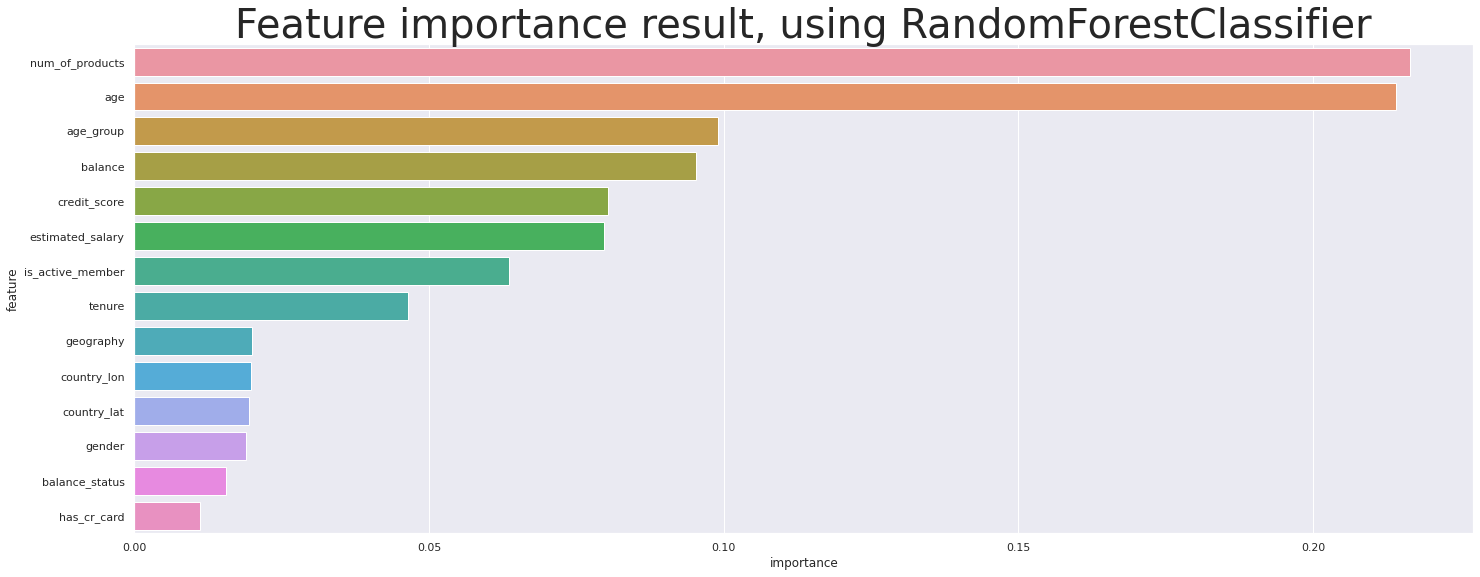

In [72]:
sns.barplot(x='importance', y='feature', data=df_importance)
plt.title('Feature importance result, using RandomForestClassifier', fontsize=40)
plt.show();

In [73]:
selected_cols = ['num_of_products',
                 'age',
                 'age_group',
                 'balance',
                 'credit_score',
                 'estimated_salary']

# 7.0. Model Tranning

In [149]:
X_train = X_train[selected_cols]
X_val = X_val[selected_cols]

## 7.1. KNeighborsClassifier

In [150]:
# # model definition
model_knn = neighbors.KNeighborsClassifier(n_neighbors=5, 
                                           weights='uniform', 
                                           algorithm='auto', 
                                           leaf_size=30, 
                                           p=2, 
                                           metric='minkowski', 
                                           metric_params=None, 
                                           n_jobs=None)

# model fit
model_knn.fit( X_train, y_train )


# model performance
result_knn = performance_metrics_cv( model_knn, X_train, y_train, 'KNeighborsClassifier', cv=3 )

## 7.2 SVM

In [151]:
# model definition
model_svm = svm.SVC(C=10.0, 
                    kernel='rbf', 
                    degree=3, 
                    gamma='scale', 
                    coef0=0.0, 
                    shrinking=True, 
                    probability=True, 
                    tol=0.001, 
                    cache_size=200, 
                    class_weight=None, 
                    verbose=False, 
                    max_iter=-1, 
                    decision_function_shape='ovr', 
                    break_ties=False, 
                    random_state=42)
# model fit
model_svm.fit( X_train, y_train )

# model performance
result_svm = performance_metrics_cv( model_svm, X_train, y_train, 'SVC', cv=3 )
result_svm

,Model Name,precision,recall,f1_score,accuracy,roc_auc
0,SVC,0.8681 +/- 0.0384,0.1515 +/- 0.006,0.2579 +/- 0.01,0.8209 +/- 0.0025,0.7904 +/- 0.0136


## 7.3. RandomForestClassifier

In [152]:
# model definition
model_rf = ensemble.RandomForestClassifier(n_estimators=200, 
                                           criterion='gini', 
                                           max_depth=10, 
                                           min_samples_split=2, 
                                           min_samples_leaf=1, 
                                           min_weight_fraction_leaf=0.0, 
                                           max_features='auto', 
                                           max_leaf_nodes=None, 
                                           min_impurity_decrease=0.0, 
                                           min_impurity_split=None, 
                                           bootstrap=True, 
                                           oob_score=False, 
                                           n_jobs=None, 
                                           random_state=42, 
                                           verbose=0, 
                                           warm_start=False, 
                                           class_weight=None, 
                                           ccp_alpha=0.0, 
                                           max_samples=None)
# model fit
model_rf.fit( X_train, y_train )


# model performance
result_rf = performance_metrics_cv( model_rf, X_train, y_train, 'RandomForestClassifier', cv=3 )

## 7.4. LogisticRegression

In [153]:
# model definition
model_lr = linear_model.LogisticRegression(penalty='l2', 
                                           dual=False, 
                                           tol=0.0001, 
                                           C=10.0, 
                                           fit_intercept=True, 
                                           intercept_scaling=1, 
                                           class_weight=None, 
                                           random_state=42, 
                                           solver='lbfgs', 
                                           max_iter=100, 
                                           multi_class='auto', 
                                           verbose=0, 
                                           warm_start=False, 
                                           n_jobs=None, 
                                           l1_ratio=None)
# model fit
model_lr.fit( X_train, y_train )

# model performance
result_lr = performance_metrics_cv( model_lr, X_train, y_train, 'LogisticRegression', cv=3 )

## 7.5. XGBoost Classifier

In [154]:
# model definition
model_xgb = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  eval_metric='error', 
                                  use_label_encoder=False)

# model fit
model_xgb.fit( X_train, y_train )

# model performance
result_xgb = performance_metrics_cv( model_xgb, X_train, y_train, 'XGBClassifier', cv=3 )

## 7.6. Result 

In [155]:
result = pd.concat([result_knn, result_svm, result_rf, result_lr, result_xgb]).sort_values( 'precision', ascending=False )
result

,Model Name,precision,recall,f1_score,accuracy,roc_auc
0,SVC,0.8681 +/- 0.0384,0.1515 +/- 0.006,0.2579 +/- 0.01,0.8209 +/- 0.0025,0.7904 +/- 0.0136
0,RandomForestClassifier,0.6882 +/- 0.0306,0.424 +/- 0.0178,0.5244 +/- 0.0193,0.842 +/- 0.0069,0.8283 +/- 0.0066
0,LogisticRegression,0.6731 +/- 0.0545,0.2105 +/- 0.0272,0.319 +/- 0.0303,0.8161 +/- 0.0051,0.8066 +/- 0.0103
0,XGBClassifier,0.5922 +/- 0.0074,0.4155 +/- 0.0138,0.4883 +/- 0.0121,0.8211 +/- 0.0026,0.7936 +/- 0.007
0,KNeighborsClassifier,0.5456 +/- 0.0229,0.3911 +/- 0.0134,0.4554 +/- 0.0142,0.8077 +/- 0.0063,0.7451 +/- 0.0091


## 7.7. Performance Measures

### 7.7.1. Confusion Matrix

In [99]:
y_train_pred = cross_val_predict( model_svm, X_train, y_train, cv=3  )

metrics.confusion_matrix( y_train, y_train_pred )

array([[6318,   38],
       [1395,  249]])

In [100]:
print( 'Precision: {}'.format( 249 / ( 249 + 38 ) ) )
print( 'Recall: {}'.format( 249 / ( 249 + 1395 ) ) )

Precision: 0.867595818815331
Recall: 0.15145985401459855


### 7.7.2. Precision Recall Curve

In [166]:
y_scores = cross_val_predict( model_svm, X_train, y_train, cv=3, method='decision_function' )


precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)

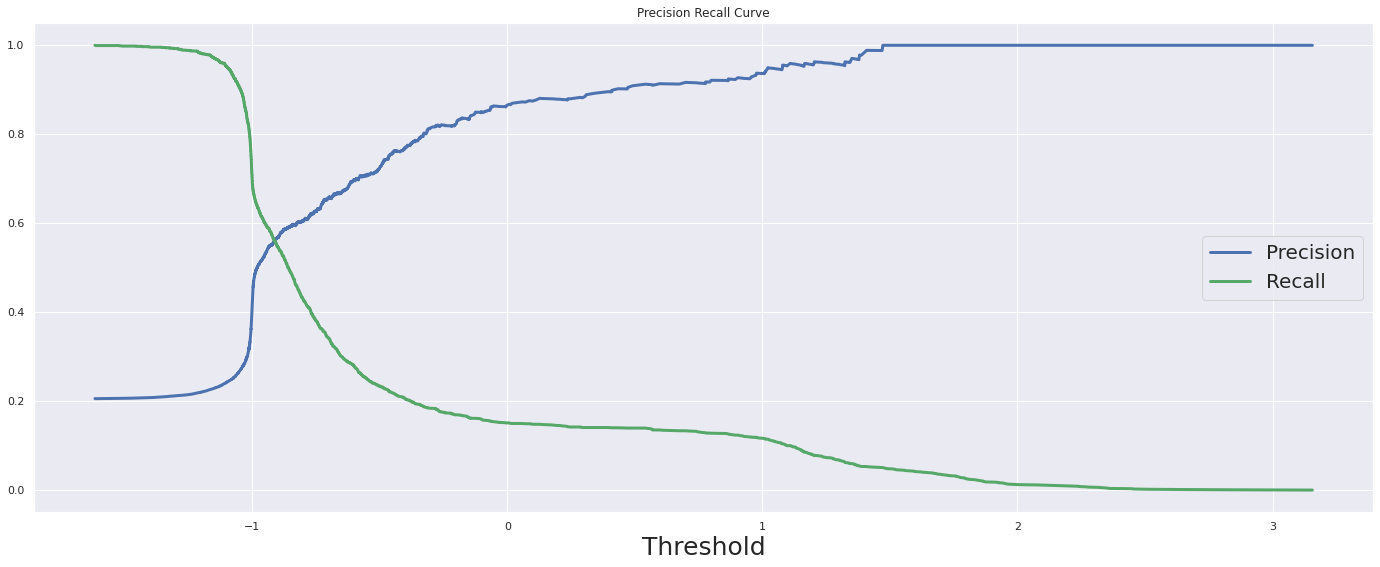

In [139]:
plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=3)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=3)
plt.legend(loc="center right", fontsize=20) 
plt.xlabel("Threshold", fontsize=25)
plt.title( 'Precision Recall Curve' )
plt.grid(True)                              

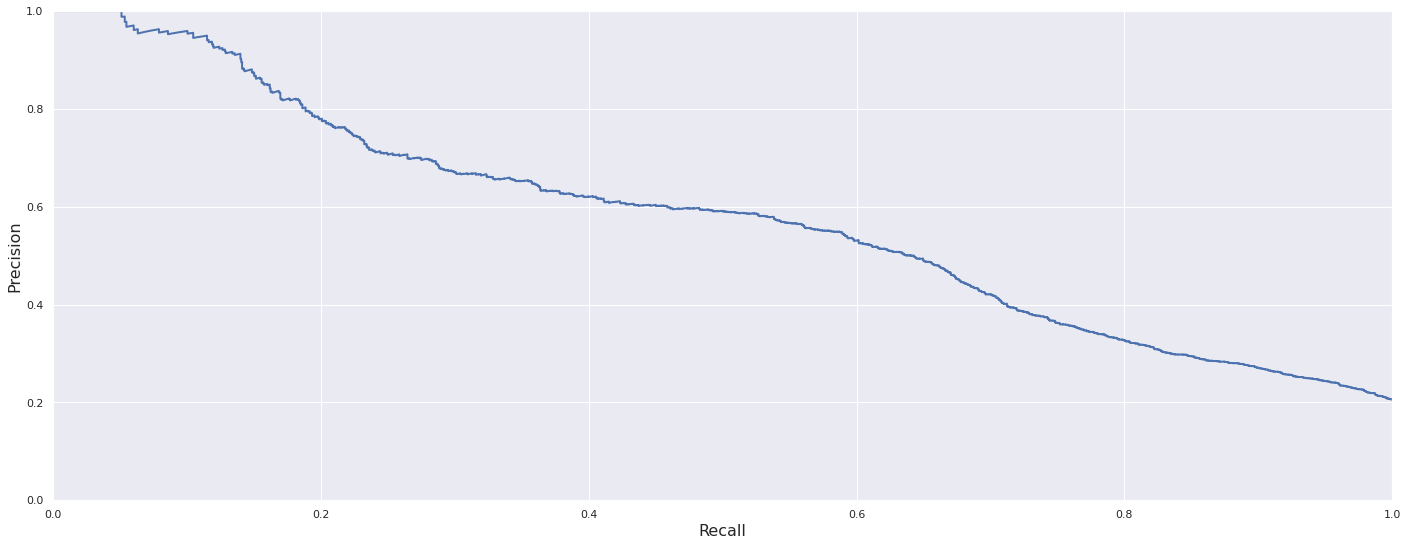

In [137]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)

### 7.7.3. The ROC Curve

In [140]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores)

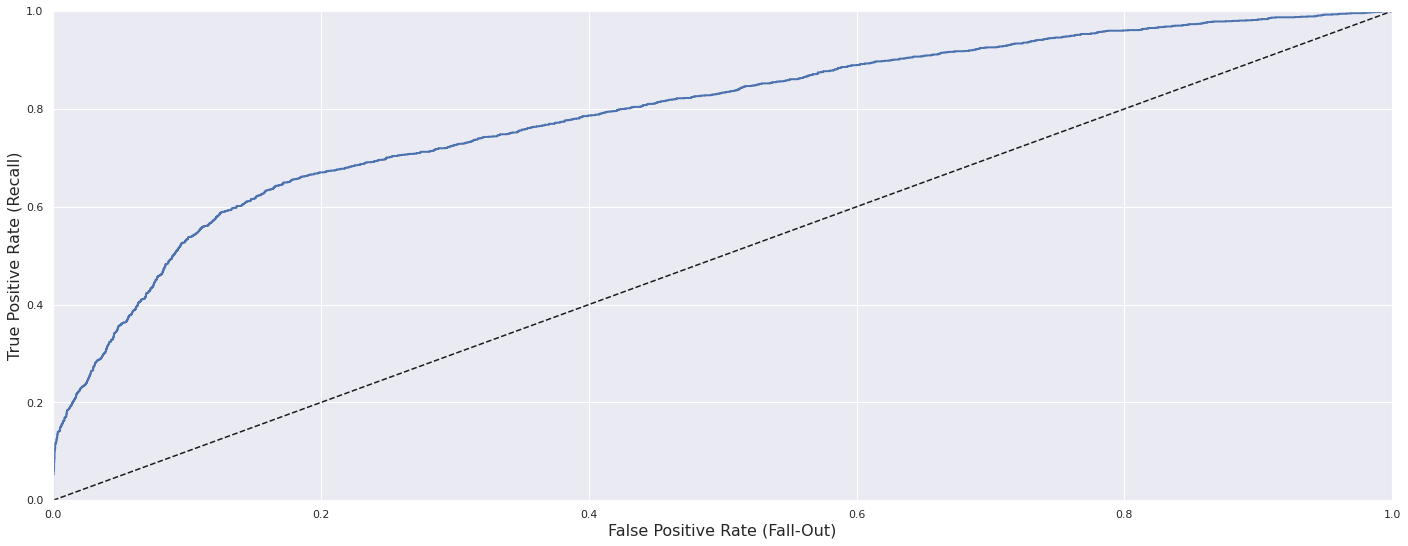

In [147]:
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])                                    
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
plt.grid(True)                                           

In [145]:
metrics.roc_auc_score(y_train, y_scores)

0.7900575581208398

# 8.0. Hyperparameter Fine-Tuning

# 9.0. Model Perfomance

# 10.0. Deploy to Production